# ML for Sustainability
## Author:Shiva Singh Bagri

**Regular Imports**

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score
from torchvision.transforms import transforms
from PIL import Image
import os
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F

**Specifying GPU for acceleration**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Utilities 
* data augmentation and transforms to prevent overfitting with eg random flip.
* image size we resizing is (224,224,3)
* normalising to a mean and standard deviation i specifically choose this mean because this is mean and std from imagenet dataset and a good representative for image datasets.
[(https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)]

In [3]:
class Data(torch.utils.data.Dataset):
    def __init__(self,images,labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.preprocess = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        assert len(self.images)==len(self.labels),"unmatched dataset"
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img = Image.open(self.images[idx])
        label = self.labels[idx]
        return self.preprocess(img), torch.tensor(label,dtype=torch.long)

## Here is mean data distribution of pixel values of all classes

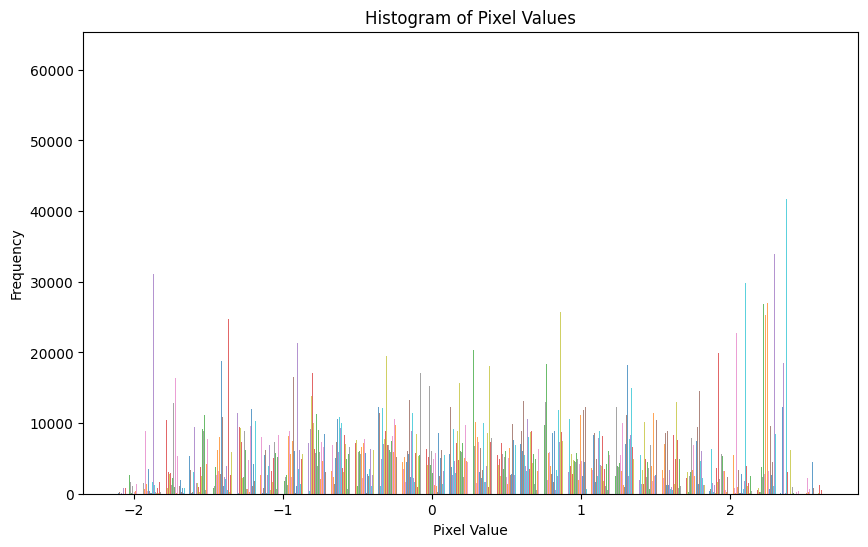

In [4]:
img_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

pixel_values = []
images = []
for folder in os.listdir(img_path):
    anim_fold = os.path.join(img_path, folder)
    for t, img_file in enumerate(os.listdir(anim_fold)):
        if t>=1:break
        img_path_full = os.path.join(anim_fold, img_file)
        images.append(img_path_full)
  
labels = [-1]*len(images)
temp_data = Data(images=images,labels=labels)
for img,label in temp_data:
    pixel_values.append(img.flatten())

# Plot histogram of pixel values
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=30, alpha=0.7)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Values')
plt.show()


## Train function
* for every epoch it first trains on train_loader and do a validation on val_loader
* here we are using tqdm for a progress bar 
* **Default hyperparameters**
* epochs per fold =: 3
* learning rate =: 1e-4
* loss function =: CrossEntropyLoss
* optimizer =: AdamW with lr = 1e-4 and defaults betas (0.9,0.99) with 0.01 default weight decay

superconvergence post[https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html]

**there are some optimizations like:**
* deleting model at end and saving best weights
* deleting images and labels sent to gpu at end
* **Half precision** for validation , since we dont have to update weights here, using half precision makes it fast for fast evaluating.

In [5]:
def train(train_loader, val_loader, model, epochs=3, lr=1e-4, model_name="model",lossf = nn.CrossEntropyLoss(),best_acc=0.0):
    model.to(device)
    model.train()
    if(os.path.exists(f"{model_name}_model.pth")):
        model.load_state_dict(torch.load(f"{model_name}_model.pth"))  #saving best weights
        print(f"weights of {model_name} loaded")
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    
    losslist = []
    accuracylist = []
    y_true = []
    y_pred = []
    
    for epoch in range(epochs):
        # Training loop
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        #progress bar 
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} (Training) for {model_name}")
        for batch_idx, (imgs, labels) in train_progress:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = lossf(out, labels)
            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            total_loss += loss.item() 
            _, predicted = torch.max(out.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            loss_now = total_loss / (batch_idx + 1)
            accuracy_now = total_correct / total_samples
            train_progress.set_postfix(loss=loss_now, acc=accuracy_now)
            del imgs, labels
            
        # Validation loop
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{epochs} (Validation) for {model_name}")
        model.eval()
        #model.eval() to turn dropout off and stop tracking gradients
        with torch.no_grad():
            for batch_idx, (imgs, labels) in val_progress:
                imgs, labels = imgs.to(device), labels.to(device)
                with torch.autocast(device_type="cuda"):##Half preicision
                    out = model(imgs)
                    loss = lossf(out, labels)
                total_val_loss += loss.item() 
                _, predicted = torch.max(out.data, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)
                val_loss_now = total_val_loss / (batch_idx + 1)
                val_accuracy_now = total_val_correct / total_val_samples
                val_progress.set_postfix(loss=val_loss_now, acc=val_accuracy_now)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                del imgs, labels
                
        losslist.append(total_val_loss / len(val_loader))
        val_acc = total_val_correct / total_val_samples
        accuracylist.append(val_acc)
        #saving best model
        if val_acc > best_acc:
            best_acc = val_acc
            save(model, f"{model_name}_model.pth")
            print(f"{model_name} weights saved with best accuracy :{best_acc}")
                
        model.train()
        
    del model
    print("Training completed weight saved.")
    return losslist, accuracylist, y_true, y_pred, best_acc

def save(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


## Main One vs Rest binary classification function
* Here we will select some class and then perform binary classification on it means, we assign 1 label to selected class and 0 label to other classes and then take loss by **CrossEntropy** and perform weights update.
*  for every data class we will make a train and Validation Dataloader for 3 folds and collect data like loss and accuracy to plot

## Dataloader
* taking images from a particular data index class and other data classes, and for binary classification we set data index class labels as 1 and other labels as 0
* here take is a parameter which defines how much to take from other classes currently we take 10% of other classes and it works.
* setting number of workers 2 and pin memory for faster data caching
* SubsetRandomSampler for selecting indices

**Batch Size**
* batch size is 32
* since GPU we are using P100 has enough memory and bottleneck is not gpu but cpu for data caching.

In [6]:
def one_vs_rest(model,model_name, data_index, n_fold=3,batch_size=32, num_workers=2,img_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals",best_acc=0.0):
    # Data loading
    images = []
    labels = []
    for folder in os.listdir(img_path):
        anim_fold = os.path.join(img_path, folder)
        if folder == os.listdir(img_path)[data_index]:
            take = 1
        else:
            take = 0.25
        tot_len = len(os.listdir(anim_fold))
        for t,img_file in enumerate(os.listdir(anim_fold)):
            if t>=take*tot_len:
                break
            img_path_full = os.path.join(anim_fold, img_file)
            images.append(img_path_full)
            if folder == os.listdir(img_path)[data_index]:
                labels.append(1)
            else:
                labels.append(0)
    images = np.array(images)
    labels = np.array(labels)
    
    # Define dataset and indices
    dataset = Data(images=images, labels=labels)
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)##3 fold 
    
    allloss = {"fold1":[],"fold2":[],"fold3":[]}
    allacc = {"fold1":[],"fold2":[],"fold3":[]}
    ally_true = {"fold1":[],"fold2":[],"fold3":[]}
    ally_pred = {"fold1":[],"fold2":[],"fold3":[]}
    

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)

        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers, pin_memory=True)

        print(f"Fold {fold+1}:")  
        
        losslist, acclist, y_true, y_pred, best_acc = train(train_loader, val_loader, model,  model_name=model_name, best_acc=best_acc)
        allloss[f"fold{fold+1}"].append(losslist)
        allacc[f"fold{fold+1}"].append(acclist)
        ally_true[f"fold{fold+1}"].append(y_true)
        ally_pred[f"fold{fold+1}"].append(y_pred)
        
    return allloss,allacc,ally_true,ally_pred, best_acc


## CustomModel
* **We used model with AttentionBlock to emphasize the importance of image patches.to focus on important part of images and discared irrelevant parts.although it is helpful in medical datasets but in animal datasets maybe there is a big landscape with animal in small pixels for eg with birds, there attention will be useful.**

## *Components*

# Convolution Blocks
* There are 5 Conv Blocks each constituting:
* conv2d batchnorm relu conv2d batchnorm relu and maxpool at the end
* these convblocks are commonly used.
* batchnorm is used to stabilise training from covariate shift [https://arxiv.org/abs/1502.03167]
* ReLU is used as an activation function as used by imagenet paper.

# Hyperparameters
* kernel size : 3 for Conv filters and :=2 for MaxPooling


## Attention Block
* The intermediate features is the output of pool-3 or pool-4 and the global feature vector (output of pool-5) is fed as input to the attention layer.
* feature upsampling is done via bilinear interpolation to mak intermediate and global feature vector same shape.
* After that an element wise sum is done followed by a convolution operation that just reduces the 256 channels to 1.
* This is then fed into a Softmax layer, which gives us a normalized Attention map (A). Each scalar element in A represents the degree of attention to the corresponding spatial feature vector in F.
* The new feature vector 𝐹̂ is then computed by pixel-wise multiplication. That is, each feature vector f is multiplied by the attention element a
* So, the attention map A and the new feature vector 𝐹̂ are the outputs of the Attention Layer.

[https://github.com/SaoYan/IPMI2019-AttnMel/blob/99e4a9b71717fb51f24d7994948b6a0e76bb8d58/networks.py]


## Initialising
* we initialise with kaiming normal to prevent gradient vanishing or exploding latter on.

* Conv2d Layers: initializes the weights using the Kaiming normal.

* BatchNorm2d Layers: it sets the weights to 1 and biases to 0.

* Linear Layers: initializes the weights from a normal distribution with mean 0 and standard deviation 0.01. It sets the biases to 0.

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

class Model(nn.Module):
    def __init__(self, num_classes, normalize_attn=False):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.pool = nn.AvgPool2d(7, stride=1)
     
        self.cls = nn.Linear(in_features=768, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
               
        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
    
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    
    def forward(self, x):
        block1 = self.conv_block1(x)       # /2
        block2 = self.conv_block2(block1)  # /4
        block3 = self.conv_block3(block2)  # /8
        block4 = self.conv_block4(block3)  # /16
        block5 = self.conv_block5(block4)  # /32
        N, __, __, __ = block5.size()
        
        g = self.pool(block5).view(N,512)
        a1, g1 = self.attn1(block3, block5)
        g_hat = torch.cat((g,g1), dim=1) # batch_size x C
        out = self.cls(g_hat)

        return out


In [8]:
model = Model(2)
x = torch.randn((8,3,224,224))
model(x)

tensor([[ 0.1368, -0.0015],
        [ 0.1678, -0.0365],
        [ 0.1938,  0.0303],
        [ 0.1695, -0.0208],
        [ 0.1785,  0.0083],
        [ 0.1693, -0.0036],
        [ 0.1895, -0.0057],
        [ 0.1759,  0.0108]], grad_fn=<AddmmBackward0>)

## Now we just for every data class perform One vs Rest classification for : 
* **Resnet**
* **EfficientNet**
* **CustomModel**

## |Note : i am currently performing for only 5 selected class, due to compute unavailability and kaggle GPU just stucks after some hours.

# Resnet

In [9]:
##
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512,2)

allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timer = []

best_acc_resnet = 0.0
n_classes = 5

for data_idx in range(n_classes):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_resnet = one_vs_rest(resnet,"Resnet_bi",data_idx,best_acc=best_acc_resnet)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timer.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1:
weights of Resnet_bi loaded


Epoch 1/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s, acc=1, loss=0.00301]

Model saved to Resnet_bi_model.pth
Resnet_bi weights saved with best accuracy :1.0



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s, acc=0.998, loss=0.00615]

Training completed weight saved.
Fold 2:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s, acc=0.998, loss=0.003]  

Training completed weight saved.
Fold 3:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, acc=1, loss=0.00121]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:92.78 seconds
Fold 1:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s, acc=0.994, loss=0.0176]

Training completed weight saved.
Fold 2:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s, acc=0.985, loss=0.0463]


Training completed weight saved.
Fold 3:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s, acc=0.983, loss=0.0682]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:95.27 seconds
Fold 1:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s, acc=0.989, loss=0.0269]

Training completed weight saved.
Fold 2:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s, acc=0.978, loss=0.0405]


Training completed weight saved.
Fold 3:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s, acc=0.996, loss=0.0139]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:94.57 seconds
Fold 1:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s, acc=0.985, loss=0.0601]

Training completed weight saved.
Fold 2:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s, acc=0.978, loss=0.0565]

Training completed weight saved.
Fold 3:
weights of Resnet_bi loaded



Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s, acc=0.983, loss=0.0532]


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:96.31 seconds
Fold 1:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, acc=0.996, loss=0.0141]


Training completed weight saved.
Fold 2:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s, acc=0.985, loss=0.0378]


Training completed weight saved.
Fold 3:
weights of Resnet_bi loaded


Epoch 3/3 (Validation) for Resnet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s, acc=0.996, loss=0.00746]

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:94.90 seconds


## Since 90 classes are lot, we will plot foldwise mean of loss accuracy and confusion matrix for **all classes**
## Resnet Plots

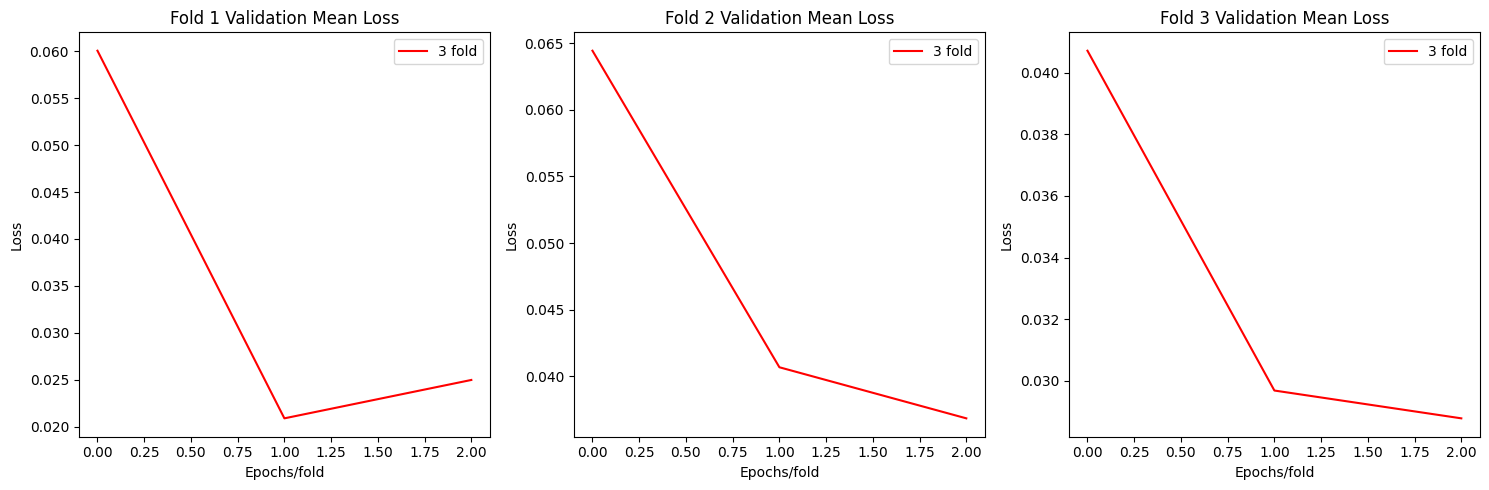

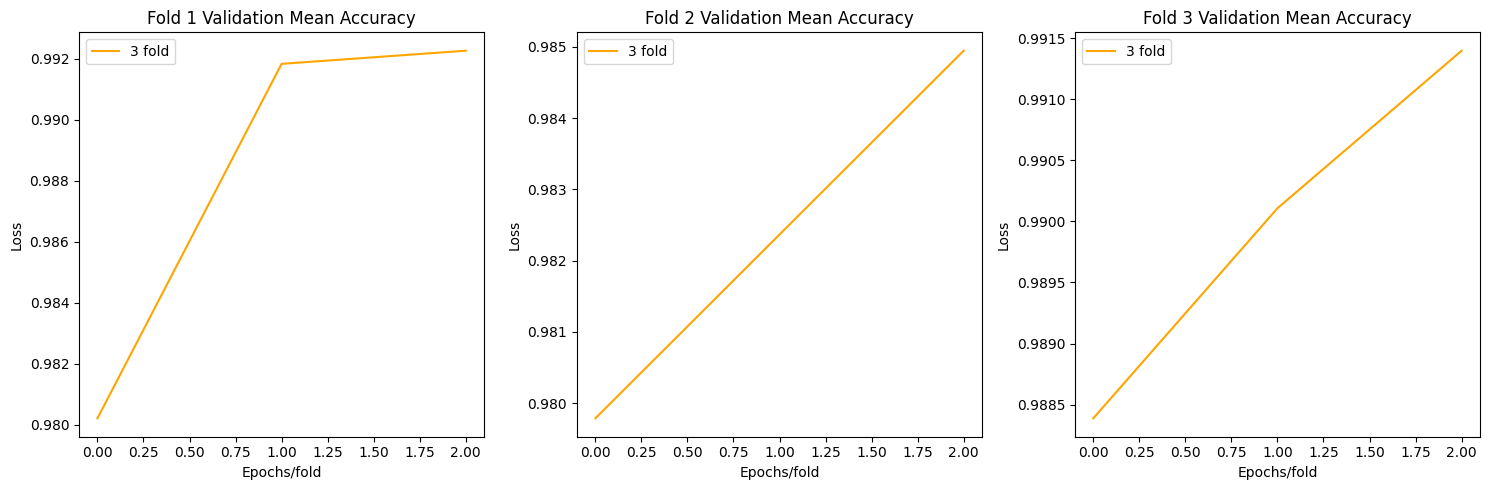

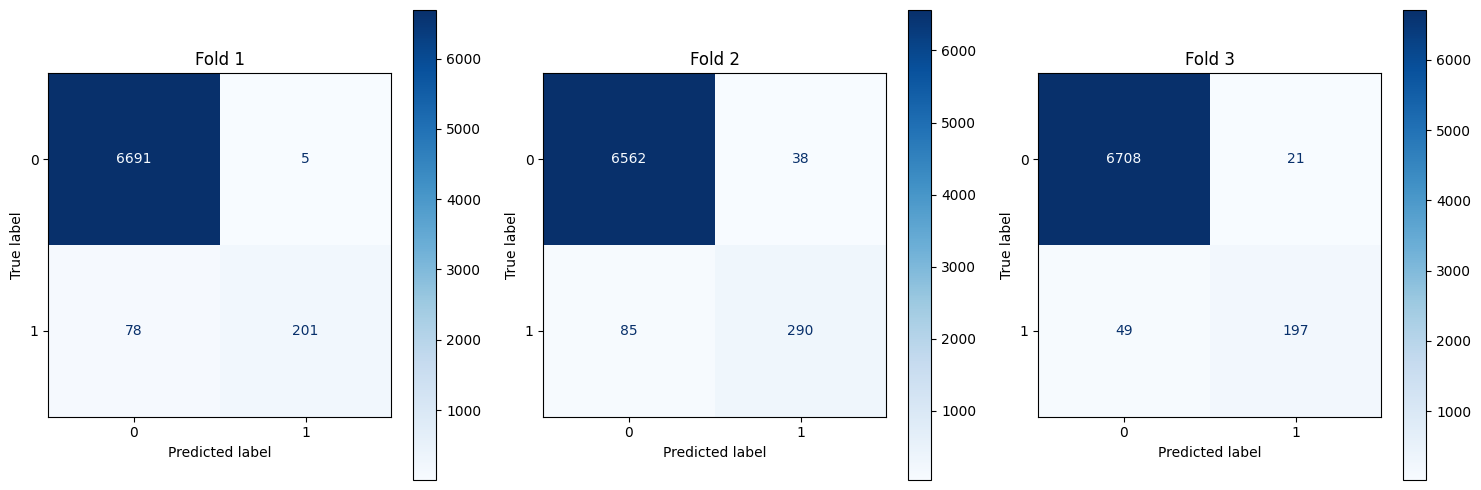

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)


# EfficientNet b0


In [11]:
##
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(1280,2)

allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timee = []

best_acc_eff = 0.0
for data_idx in range(n_classes):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_eff = one_vs_rest(efficientnet,"EfficientNet_bi",data_idx,best_acc=best_acc_eff)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timee.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1:
weights of EfficientNet_bi loaded


Epoch 1/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s, acc=1, loss=0.00237]

Model saved to EfficientNet_bi_model.pth
EfficientNet_bi weights saved with best accuracy :1.0



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s, acc=1, loss=0.00438]


Training completed weight saved.
Fold 2:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, acc=1, loss=0.0013] 

Training completed weight saved.
Fold 3:
weights of EfficientNet_bi loaded



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, acc=1, loss=0.00127]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:100.31 seconds
Fold 1:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s, acc=0.994, loss=0.0253]


Training completed weight saved.
Fold 2:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s, acc=0.978, loss=0.0637]


Training completed weight saved.
Fold 3:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s, acc=0.981, loss=0.0593]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:99.64 seconds
Fold 1:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s, acc=0.987, loss=0.0468]

Training completed weight saved.
Fold 2:
weights of EfficientNet_bi loaded



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s, acc=0.97, loss=0.069]  

Training completed weight saved.
Fold 3:
weights of EfficientNet_bi loaded



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.20it/s, acc=0.981, loss=0.0597]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:100.25 seconds
Fold 1:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, acc=0.985, loss=0.0354]


Training completed weight saved.
Fold 2:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s, acc=0.981, loss=0.0688]

Training completed weight saved.
Fold 3:
weights of EfficientNet_bi loaded



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s, acc=0.978, loss=0.0533]


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:99.29 seconds
Fold 1:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s, acc=0.996, loss=0.0194]

Training completed weight saved.
Fold 2:
weights of EfficientNet_bi loaded



Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s, acc=0.974, loss=0.0559]


Training completed weight saved.
Fold 3:
weights of EfficientNet_bi loaded


Epoch 3/3 (Validation) for EfficientNet_bi: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s, acc=0.991, loss=0.0277]

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:99.12 seconds


# EfficientNet Plots

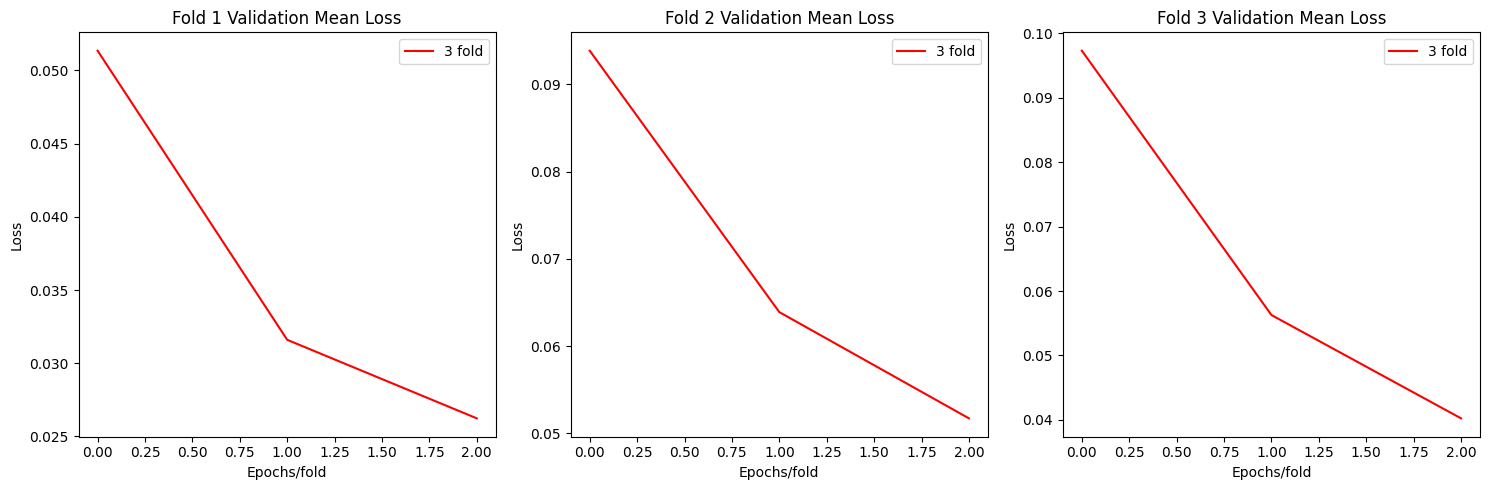

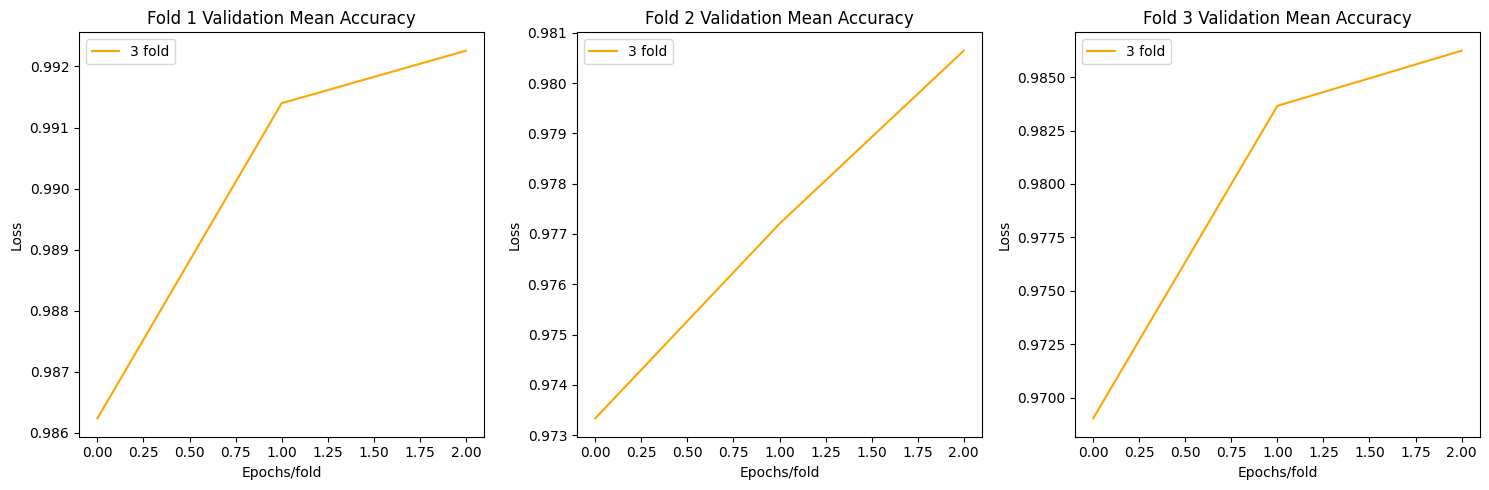

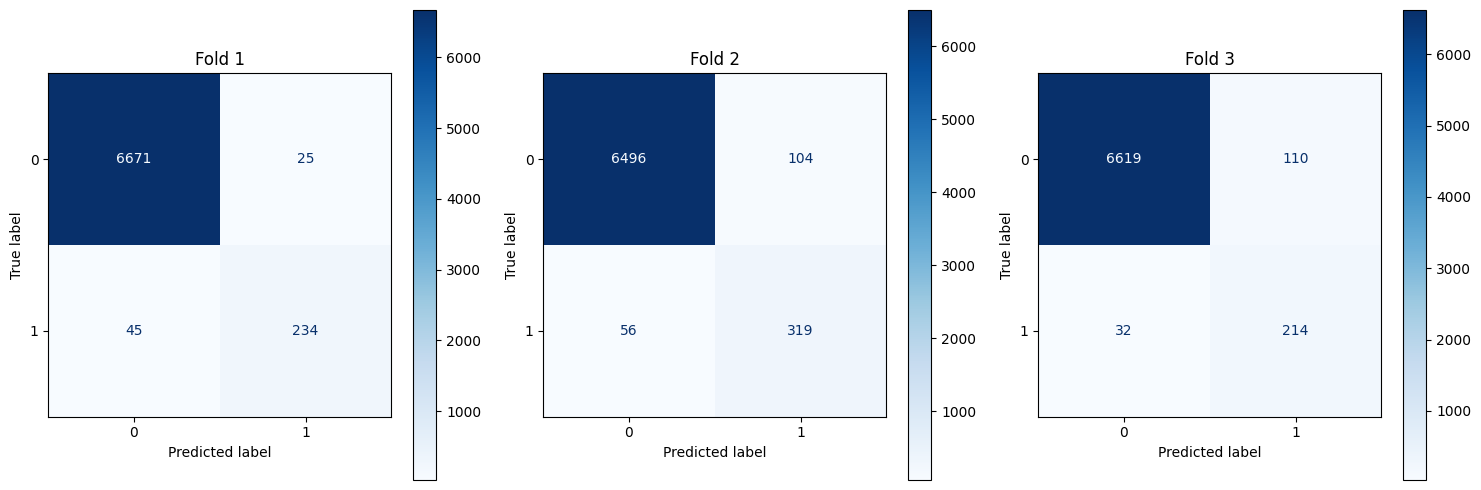

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)


## CustomModel

In [13]:
##
allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timec = []

best_acc_cust = 0.0
for data_idx in range(n_classes):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_cust = one_vs_rest(model,"CustomAttModel_bi",data_idx,best_acc=best_acc_cust)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timec.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

Fold 1:


Epoch 1/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s, acc=0.968, loss=0.148]

Model saved to CustomAttModel_bi_model.pth
CustomAttModel_bi weights saved with best accuracy :0.967741935483871



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s, acc=0.927, loss=0.249]

Training completed weight saved.
Fold 2:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s, acc=0.951, loss=0.197]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s, acc=0.951, loss=0.196]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:112.75 seconds
Fold 1:
weights of CustomAttModel_bi loaded


Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s, acc=0.966, loss=0.12] 

Training completed weight saved.
Fold 2:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s, acc=0.935, loss=0.216]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s, acc=0.959, loss=0.125]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:112.96 seconds
Fold 1:
weights of CustomAttModel_bi loaded


Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s, acc=0.953, loss=0.149]

Training completed weight saved.
Fold 2:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s, acc=0.933, loss=0.183]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_bi loaded



Epoch 1/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.18it/s, acc=0.972, loss=0.132]


Model saved to CustomAttModel_bi_model.pth
CustomAttModel_bi weights saved with best accuracy :0.9720430107526882


Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s, acc=0.972, loss=0.126]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:113.43 seconds
Fold 1:
weights of CustomAttModel_bi loaded


Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s, acc=0.957, loss=0.153]

Training completed weight saved.
Fold 2:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s, acc=0.944, loss=0.174]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s, acc=0.97, loss=0.116] 


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:116.66 seconds
Fold 1:
weights of CustomAttModel_bi loaded


Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s, acc=0.963, loss=0.11] 

Training completed weight saved.
Fold 2:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s, acc=0.953, loss=0.143]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_bi loaded



Epoch 3/3 (Validation) for CustomAttModel_bi: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s, acc=0.97, loss=0.0866] 

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:112.79 seconds


# CustomModel Plots

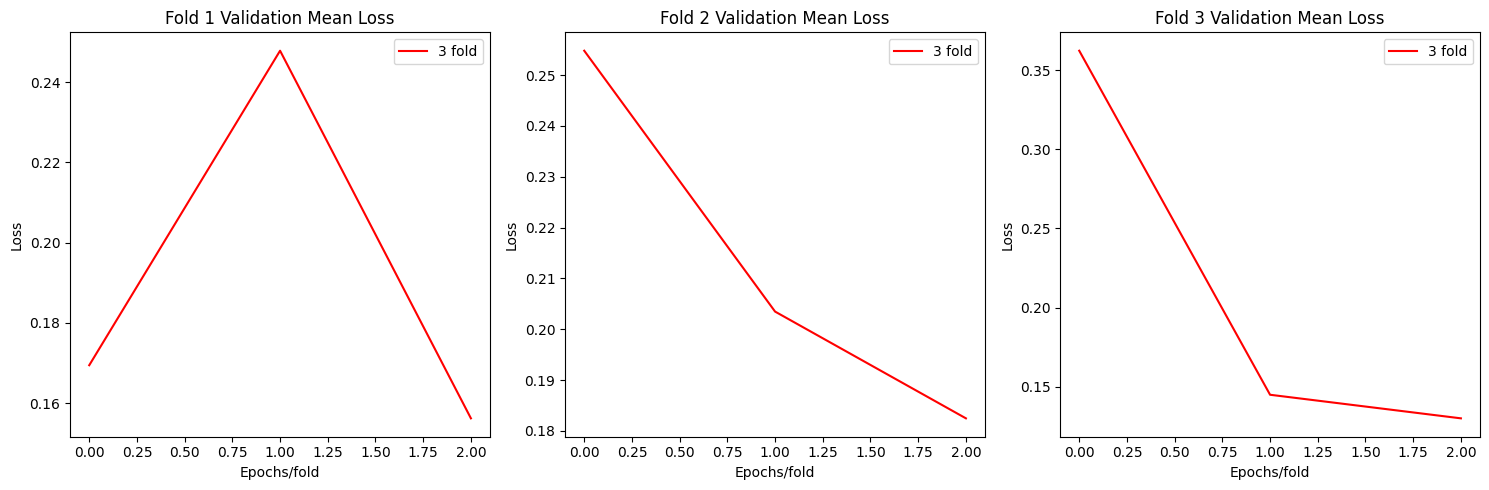

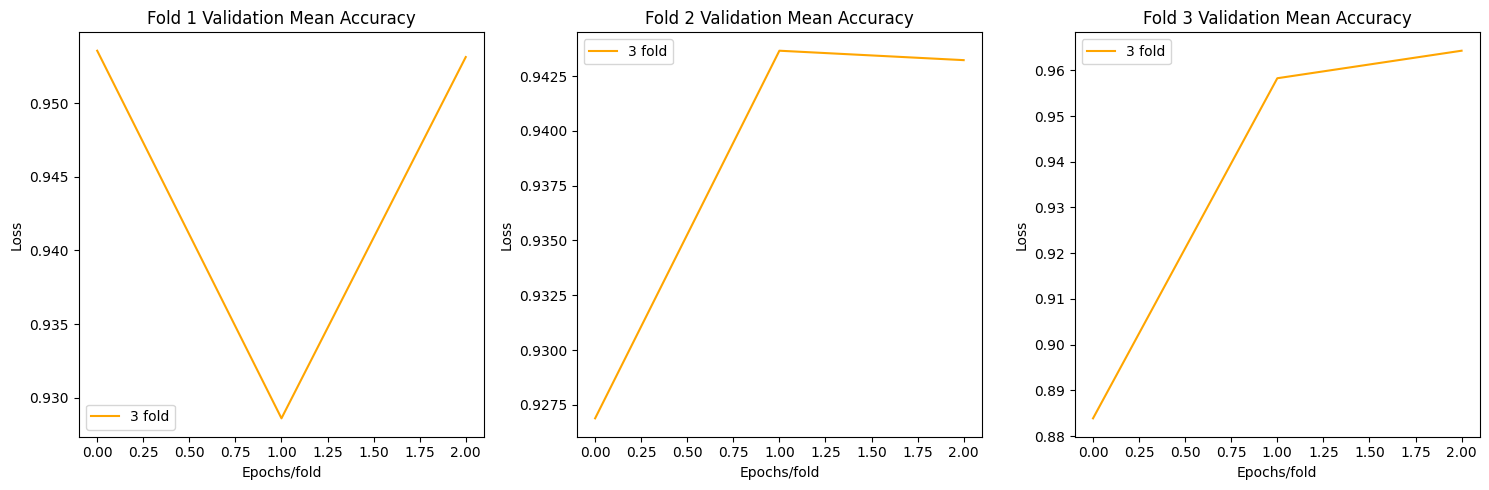

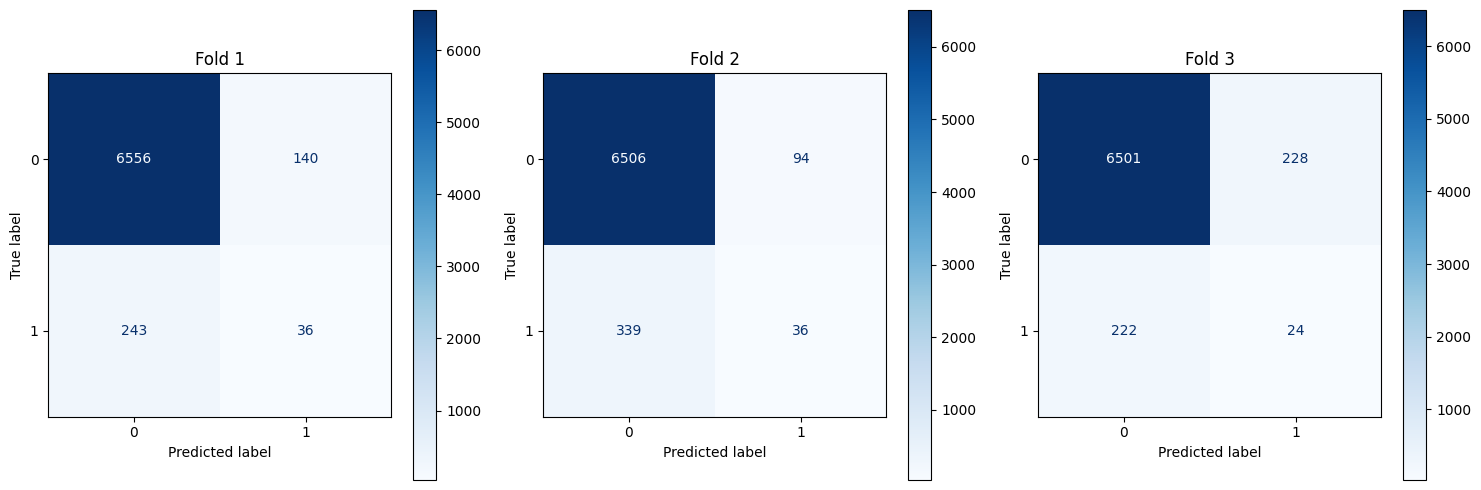

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)

## Comparing Best Accuracy on Validation

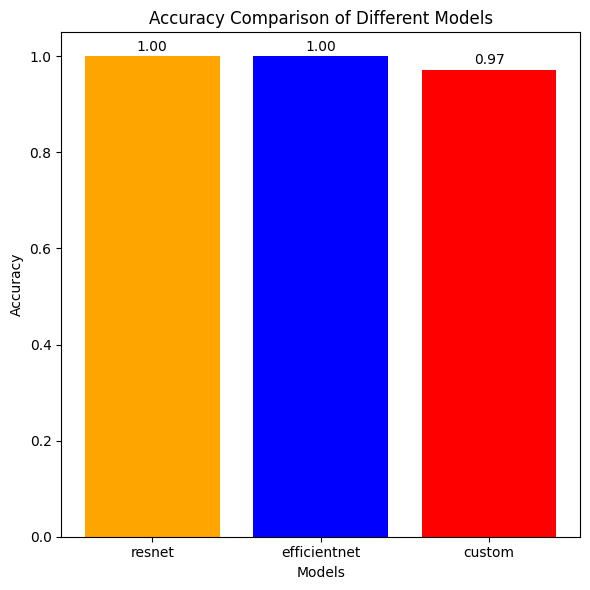

In [15]:
models = ["resnet", "efficientnet", "custom"]
accuracies = [best_acc_resnet, best_acc_eff, best_acc_cust]

# Define a colormap
colors = ["orange","blue","red"]

plt.figure(figsize=(6, 6))
bars = plt.bar(models, accuracies, color=colors)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Adding the accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{accuracy:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Time Taken

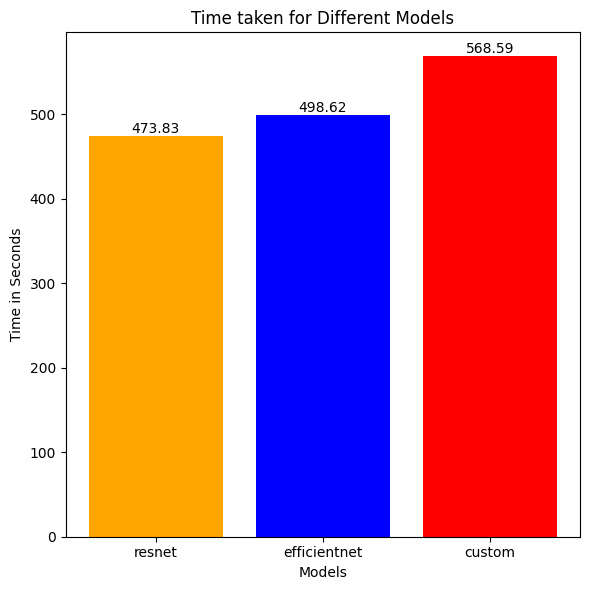

In [16]:
models = ["resnet", "efficientnet", "custom"]
time = [np.sum(timer), np.sum(timee), np.sum(timec)]

# Define a colormap
colors = ["orange","blue","red"]

plt.figure(figsize=(6, 6))
bars = plt.bar(models, time, color=colors)

plt.xlabel('Models')
plt.ylabel('Time in Seconds')
plt.title('Time taken for Different Models')

for bar, time in zip(bars, time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{time:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Five class classification

# in here, we have taken 5 - 5 classes, means 16 parts of 90 class dataset each containing 5 classes and perfomed classification.
# for example take classes [0,5) then perform classification then [5,10) etc.

In [17]:
def five_class_classify(model,model_name, data_index, n_fold=3,batch_size=32, num_workers=2,img_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals",best_acc=0.0):
    # Data loading
    images = []
    labels = []
    for offset,folder in enumerate(os.listdir(img_path)[data_index*5:data_index*5+5]):
        anim_fold = os.path.join(img_path, folder)
        for img_file in os.listdir(anim_fold):
            img_path_full = os.path.join(anim_fold, img_file)
            images.append(img_path_full)
            labels.append(offset)
            
    images = np.array(images)
    labels = np.array(labels)
    
    # Define dataset and indices
    dataset = Data(images=images, labels=labels)
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    allloss = {"fold1":[],"fold2":[],"fold3":[]}
    allacc = {"fold1":[],"fold2":[],"fold3":[]}
    ally_true = {"fold1":[],"fold2":[],"fold3":[]}
    ally_pred = {"fold1":[],"fold2":[],"fold3":[]}
    

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)

        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers, pin_memory=True)

        print(f"Fold {fold+1}:")  
        
        losslist, acclist, y_true, y_pred, best_acc = train(train_loader, val_loader, model,  model_name=model_name, best_acc=best_acc)
        allloss[f"fold{fold+1}"].append(losslist)
        allacc[f"fold{fold+1}"].append(acclist)
        ally_true[f"fold{fold+1}"].append(y_true)
        ally_pred[f"fold{fold+1}"].append(y_pred)
        
    return allloss,allacc,ally_true,ally_pred, best_acc


# Resnet

In [18]:
##
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512,5)

allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timer = []

best_acc_resnet = 0.0
n_classes = 5
for data_idx in range(5):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_resnet = one_vs_rest(resnet,"Resnet_five",data_idx,best_acc=best_acc_resnet)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timer.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1:


Epoch 1/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s, acc=0.987, loss=0.284]

Model saved to Resnet_five_model.pth
Resnet_five weights saved with best accuracy :0.9870967741935484



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s, acc=0.994, loss=0.0558]


Model saved to Resnet_five_model.pth
Resnet_five weights saved with best accuracy :0.9935483870967742
Training completed weight saved.
Fold 2:
weights of Resnet_five loaded


Epoch 1/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s, acc=0.998, loss=0.0255]

Model saved to Resnet_five_model.pth
Resnet_five weights saved with best accuracy :0.9978494623655914



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.20it/s, acc=0.996, loss=0.00767]

Training completed weight saved.
Fold 3:
weights of Resnet_five loaded



Epoch 1/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s, acc=1, loss=0.00628]

Model saved to Resnet_five_model.pth
Resnet_five weights saved with best accuracy :1.0



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s, acc=1, loss=0.00172]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:95.80 seconds
Fold 1:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.29it/s, acc=0.998, loss=0.013] 

Training completed weight saved.
Fold 2:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s, acc=0.987, loss=0.0383]

Training completed weight saved.
Fold 3:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s, acc=0.987, loss=0.0554]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:97.81 seconds
Fold 1:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s, acc=0.989, loss=0.0269]

Training completed weight saved.
Fold 2:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s, acc=0.989, loss=0.0333]


Training completed weight saved.
Fold 3:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s, acc=0.996, loss=0.0136]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:96.47 seconds
Fold 1:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s, acc=0.985, loss=0.0425]

Training completed weight saved.
Fold 2:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.26it/s, acc=0.985, loss=0.0527]


Training completed weight saved.
Fold 3:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s, acc=0.978, loss=0.0592]


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:97.30 seconds
Fold 1:
weights of Resnet_five loaded


Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s, acc=0.994, loss=0.0148]

Training completed weight saved.
Fold 2:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s, acc=0.989, loss=0.0585]

Training completed weight saved.
Fold 3:
weights of Resnet_five loaded



Epoch 3/3 (Validation) for Resnet_five: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s, acc=0.998, loss=0.0104] 

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:98.03 seconds


# Resnet Plots

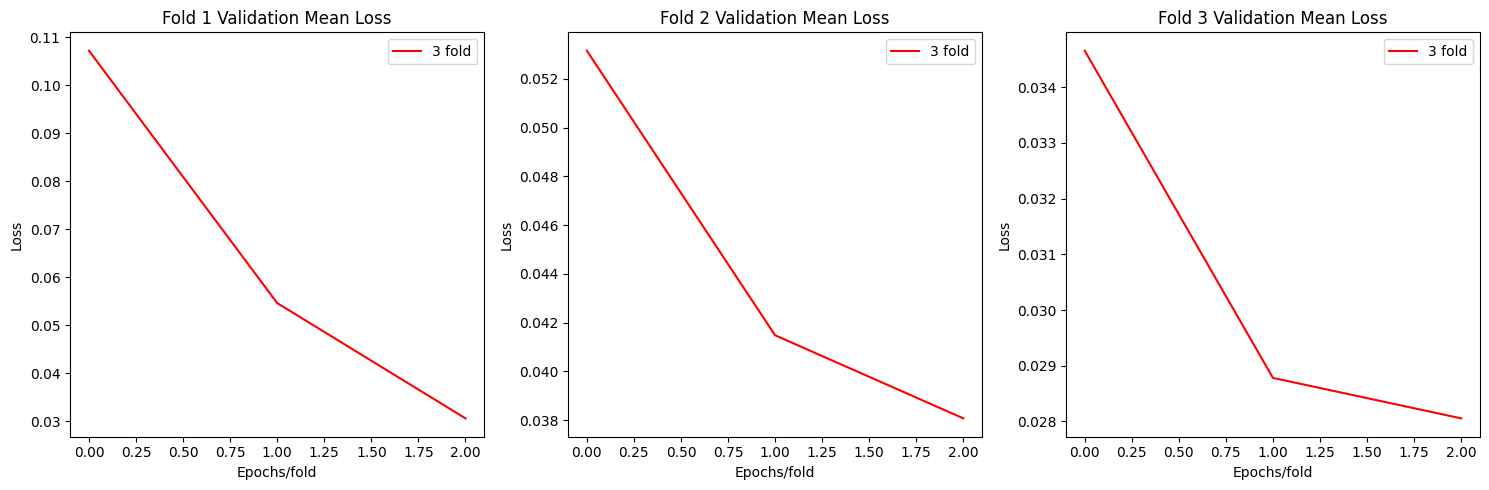

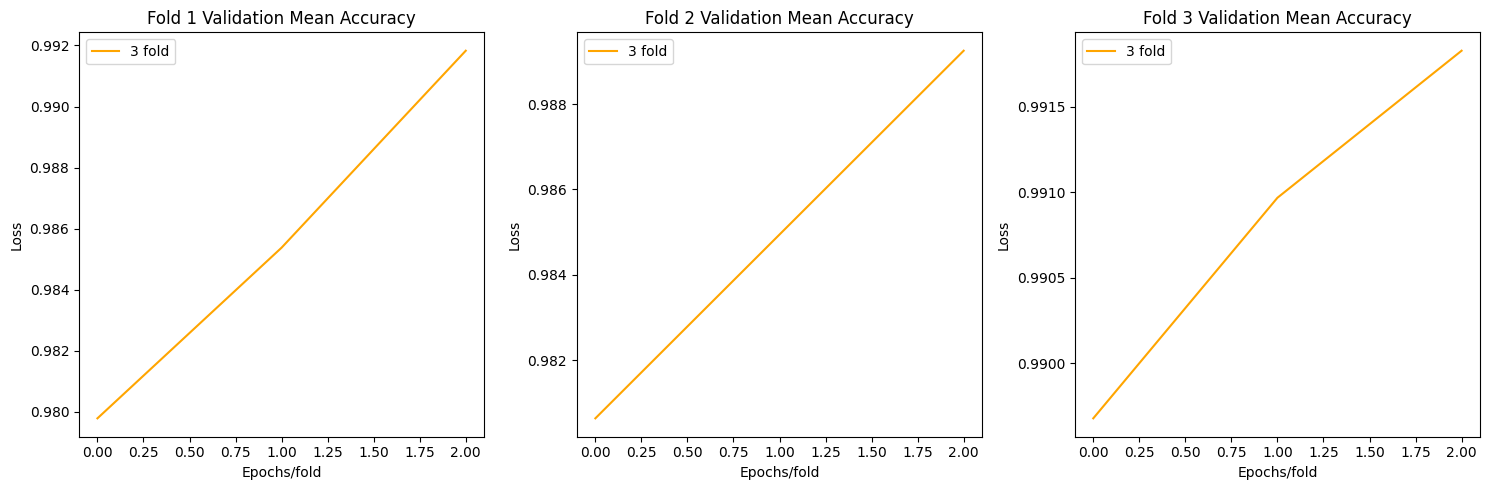

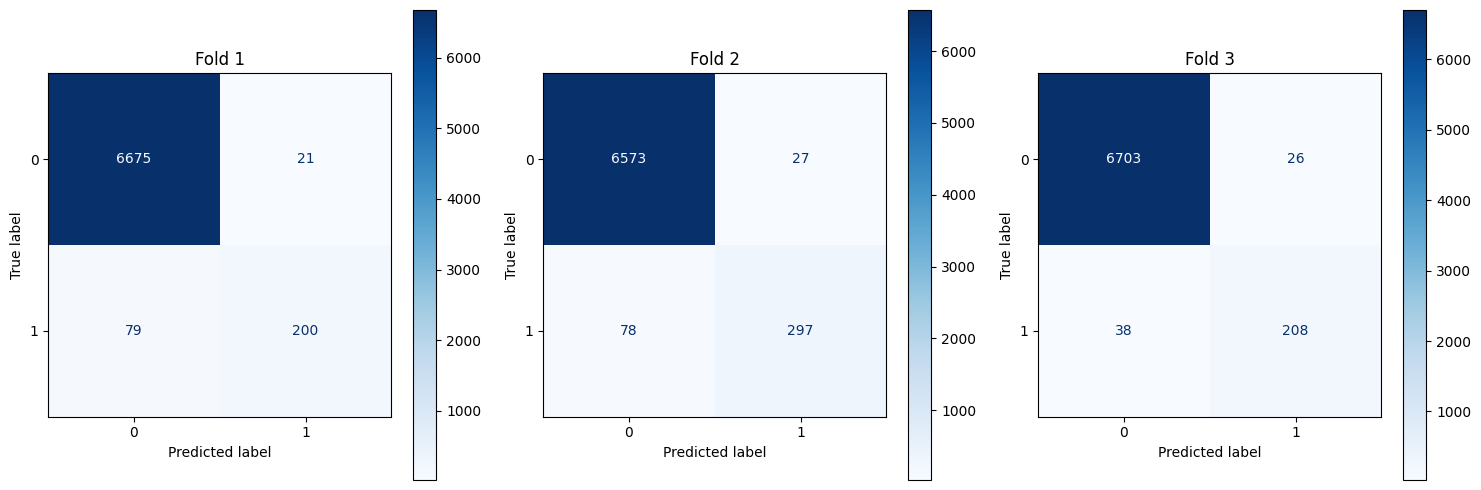

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)


# EfficientNet

In [20]:
##
import torchvision
efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(1280,5)

allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timee = []

best_acc_eff = 0.0
for data_idx in range(n_classes):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_eff = one_vs_rest(efficientnet,"EfficientNet_five",data_idx,best_acc=best_acc_eff)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timee.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1:


Epoch 1/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s, acc=0.929, loss=0.654]

Model saved to EfficientNet_five_model.pth
EfficientNet_five weights saved with best accuracy :0.9290322580645162



Epoch 2/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s, acc=0.981, loss=0.244]


Model saved to EfficientNet_five_model.pth
EfficientNet_five weights saved with best accuracy :0.9806451612903225


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s, acc=0.985, loss=0.153]


Model saved to EfficientNet_five_model.pth
EfficientNet_five weights saved with best accuracy :0.9849462365591398
Training completed weight saved.
Fold 2:
weights of EfficientNet_five loaded


Epoch 1/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.34it/s, acc=1, loss=0.0348]


Model saved to EfficientNet_five_model.pth
EfficientNet_five weights saved with best accuracy :1.0


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s, acc=0.996, loss=0.0225]

Training completed weight saved.
Fold 3:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.29it/s, acc=0.996, loss=0.0155]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:101.01 seconds
Fold 1:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s, acc=0.991, loss=0.0435]

Training completed weight saved.
Fold 2:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s, acc=0.983, loss=0.0729]

Training completed weight saved.
Fold 3:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s, acc=0.978, loss=0.0794]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:101.50 seconds
Fold 1:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s, acc=0.987, loss=0.0515]

Training completed weight saved.
Fold 2:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s, acc=0.981, loss=0.0619]


Training completed weight saved.
Fold 3:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s, acc=0.987, loss=0.0569]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:100.93 seconds
Fold 1:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s, acc=0.987, loss=0.0522]

Training completed weight saved.
Fold 2:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s, acc=0.985, loss=0.0551]

Training completed weight saved.
Fold 3:
weights of EfficientNet_five loaded



Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s, acc=0.976, loss=0.0747]


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:101.68 seconds
Fold 1:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s, acc=0.994, loss=0.029] 


Training completed weight saved.
Fold 2:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s, acc=0.983, loss=0.0377]


Training completed weight saved.
Fold 3:
weights of EfficientNet_five loaded


Epoch 3/3 (Validation) for EfficientNet_five: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s, acc=0.994, loss=0.0385]

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:101.88 seconds


# EfficientNet Plots

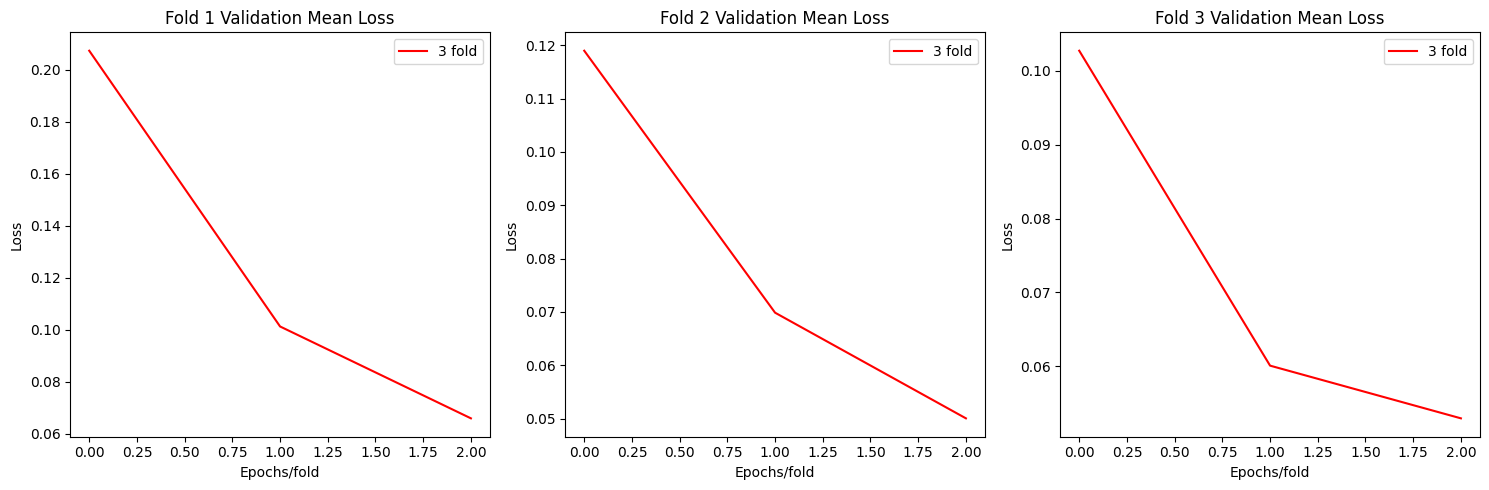

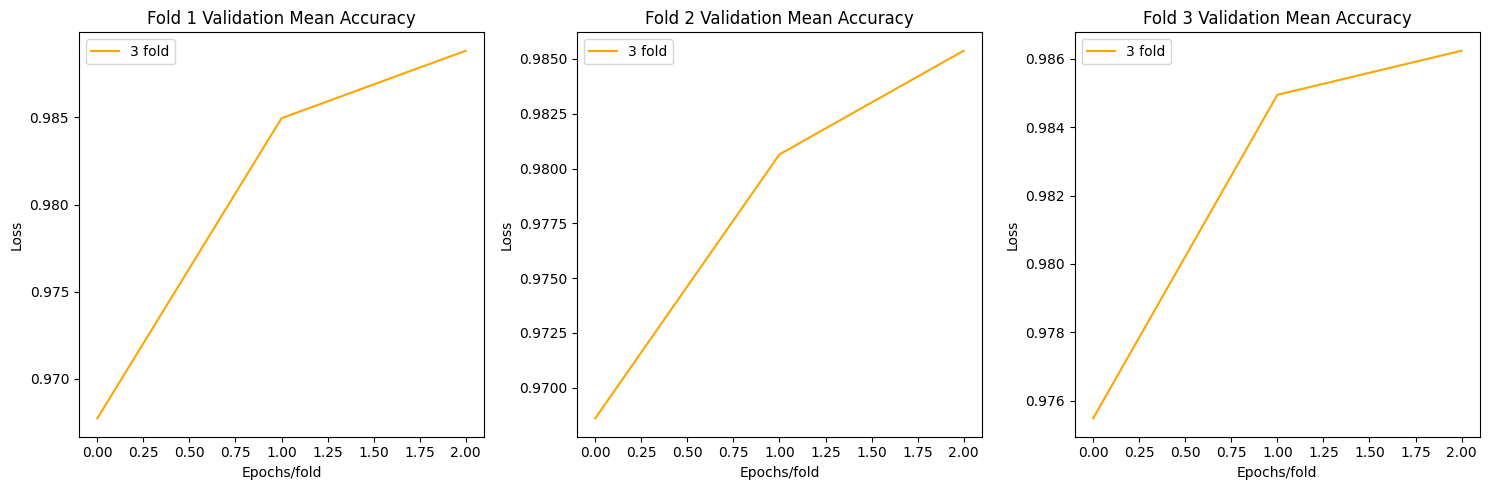

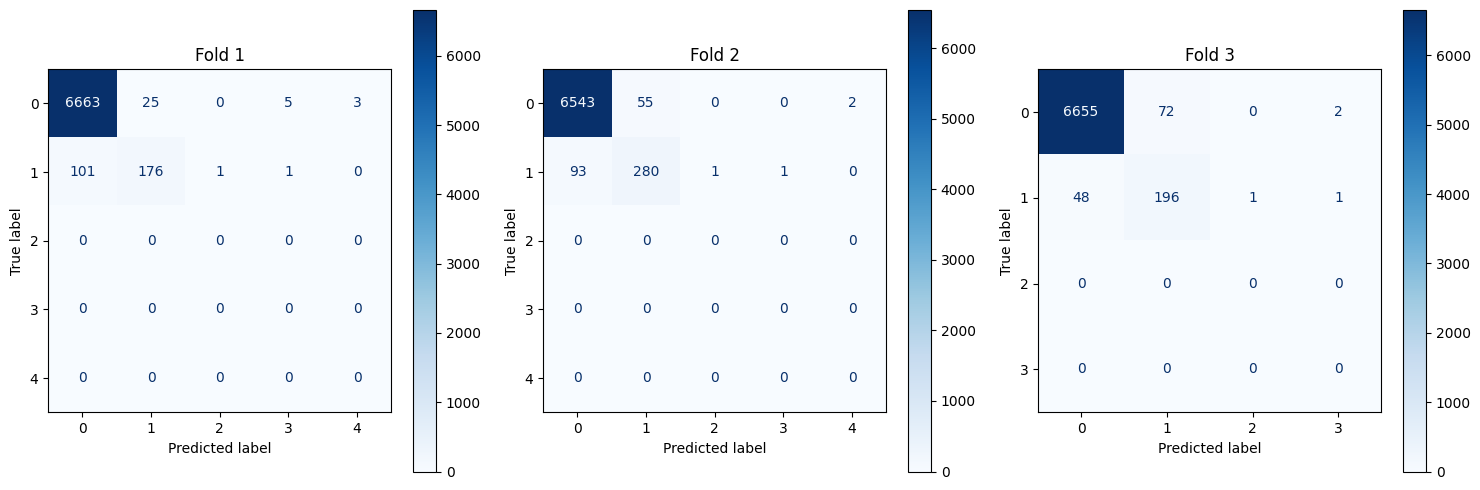

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)


# CustomModel

In [22]:
##
allloss = {"fold1":[],"fold2":[],"fold3":[]}
allacc = {"fold1":[],"fold2":[],"fold3":[]}
ally_true = {"fold1":[],"fold2":[],"fold3":[]}
ally_pred = {"fold1":[],"fold2":[],"fold3":[]}

metrics = [allloss,allacc,ally_true,ally_pred]

import time
timec = []

best_acc_cust = 0.0
for data_idx in range(n_classes):
    s = time.time()
    loss,acc,y_true,y_pred,best_acc_cust = one_vs_rest(model,"CustomAttModel_five",data_idx,best_acc=best_acc_cust)
    print(f"-------------------data_class:{data_idx+1} completed---------------")
    print(f"time elapsed:{time.time()-s:.2f} seconds")
    timec.append(time.time()-s)
    returned = [loss,acc,y_true,y_pred]
    for i,m in enumerate(metrics):
        for fold in range(3):
            m[f"fold{fold+1}"].append(returned[i][f"fold{fold+1}"])

Fold 1:


Epoch 1/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s, acc=0.862, loss=0.315]

Model saved to CustomAttModel_five_model.pth
CustomAttModel_five weights saved with best accuracy :0.8623655913978494



Epoch 2/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s, acc=0.968, loss=0.134]


Model saved to CustomAttModel_five_model.pth
CustomAttModel_five weights saved with best accuracy :0.967741935483871


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s, acc=0.968, loss=0.125]


Training completed weight saved.
Fold 2:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s, acc=0.951, loss=0.194]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s, acc=0.953, loss=0.167]


Training completed weight saved.
-------------------data_class:1 completed---------------
time elapsed:114.93 seconds
Fold 1:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s, acc=0.946, loss=0.157]

Training completed weight saved.
Fold 2:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s, acc=0.94, loss=0.159] 


Training completed weight saved.
Fold 3:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, acc=0.946, loss=0.156]


Training completed weight saved.
-------------------data_class:2 completed---------------
time elapsed:114.16 seconds
Fold 1:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s, acc=0.953, loss=0.16] 

Training completed weight saved.
Fold 2:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s, acc=0.946, loss=0.193]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_five loaded



Epoch 1/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s, acc=0.972, loss=0.127]


Model saved to CustomAttModel_five_model.pth
CustomAttModel_five weights saved with best accuracy :0.9720430107526882


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s, acc=0.972, loss=0.112]


Training completed weight saved.
-------------------data_class:3 completed---------------
time elapsed:114.28 seconds
Fold 1:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s, acc=0.957, loss=0.143]

Training completed weight saved.
Fold 2:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s, acc=0.944, loss=0.171]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s, acc=0.97, loss=0.12]  


Training completed weight saved.
-------------------data_class:4 completed---------------
time elapsed:115.25 seconds
Fold 1:
weights of CustomAttModel_five loaded


Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s, acc=0.968, loss=0.109] 

Training completed weight saved.
Fold 2:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s, acc=0.944, loss=0.169]

Training completed weight saved.
Fold 3:
weights of CustomAttModel_five loaded



Epoch 3/3 (Validation) for CustomAttModel_five: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s, acc=0.968, loss=0.125]

Training completed weight saved.
-------------------data_class:5 completed---------------
time elapsed:115.01 seconds


# CustomModel Plots

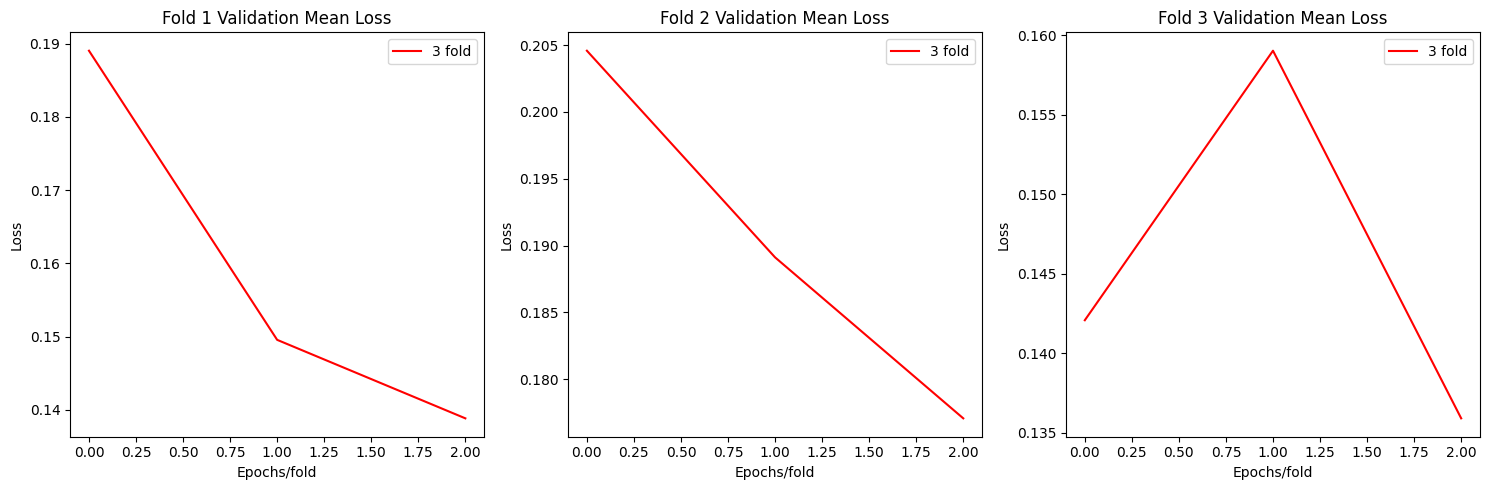

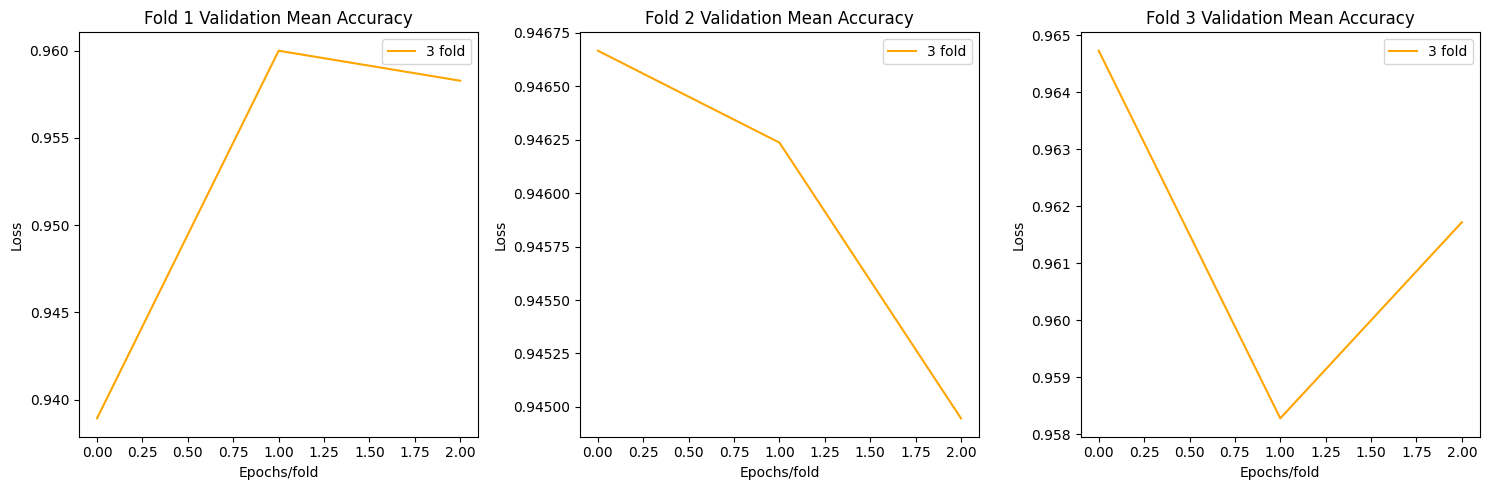

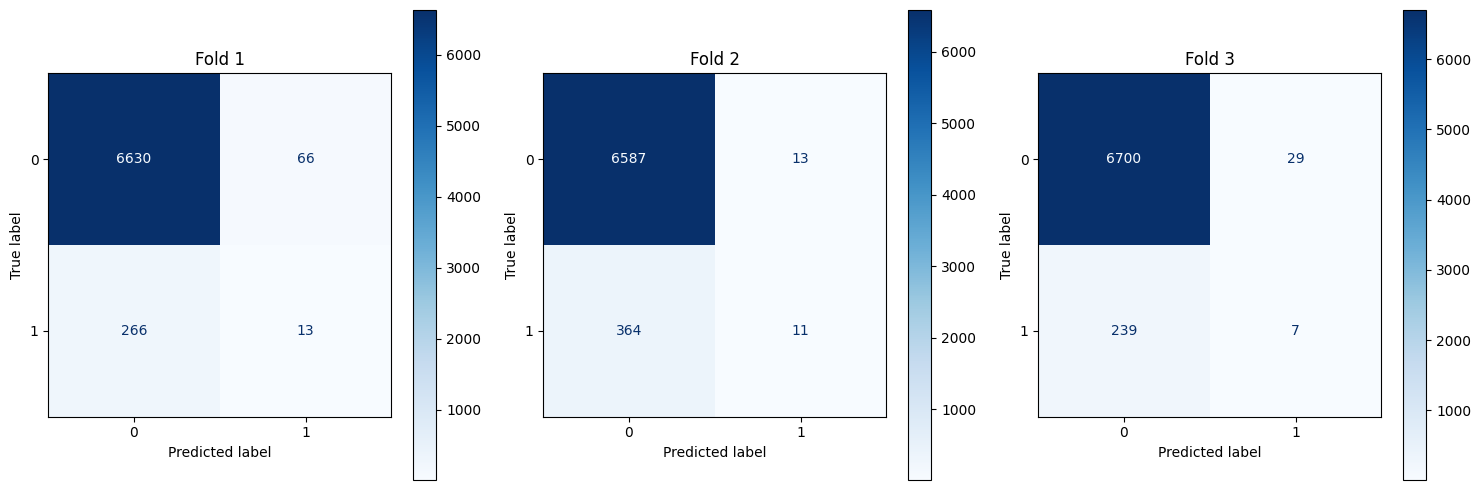

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def plot_loss(allloss):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allloss[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='red')
        axs[i].set_title(f'Fold {i+1} Validation Mean Loss')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_acc(allacc):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].plot(np.mean(allacc[f"fold{i+1}"],axis=0)[0], label=f"{fold+1} fold",c='orange')
        axs[i].set_title(f'Fold {i+1} Validation Mean Accuracy')  
        axs[i].set_xlabel('Epochs/fold')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()  
    plt.show()

def plot_cm(all_y_true, all_y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for fold in range(3):    
        real = []
        for i in range(len(ally_true[f"fold{fold+1}"])):
            real.extend(ally_true[f"fold{fold+1}"][i][0])
        pred = []
        for i in range(len(ally_pred[f"fold{fold+1}"])):
            pred.extend(ally_pred[f"fold{fold+1}"][i][0])
        cm = confusion_matrix(real, pred)
        ConfusionMatrixDisplay(cm).plot(ax=axs[fold],cmap='Blues',values_format='d')
        axs[fold].set_title(f"Fold {fold+1}")
    plt.tight_layout()
    plt.show()
plot_loss(allloss)
plot_acc(allacc)
plot_cm(ally_true,ally_pred)

# Best Accuracy on Validation

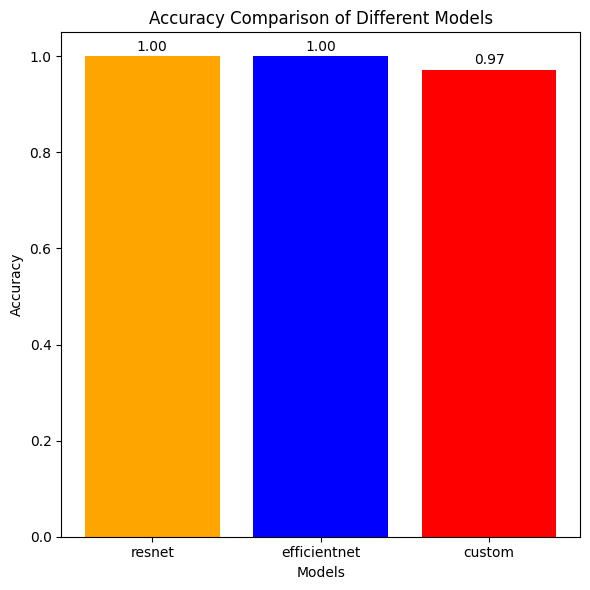

In [24]:
models = ["resnet", "efficientnet", "custom"]
accuracies = [best_acc_resnet, best_acc_eff, best_acc_cust]

# Define a colormap
colors = ["orange","blue","red"]

plt.figure(figsize=(6, 6))
bars = plt.bar(models, accuracies, color=colors)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Adding the accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{accuracy:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Time Taken

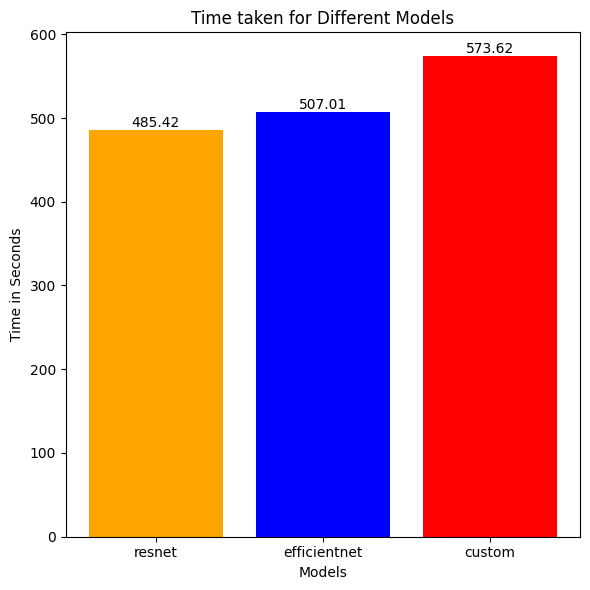

In [25]:
models = ["resnet", "efficientnet", "custom"]
time = [np.sum(timer), np.sum(timee), np.sum(timec)]

# Define a colormap
colors = ["orange","blue","red"]

plt.figure(figsize=(6, 6))
bars = plt.bar(models, time, color=colors)

plt.xlabel('Models')
plt.ylabel('Time in Seconds')
plt.title('Time taken for Different Models')

for bar, time in zip(bars, time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{time:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Visualising  Neural Nets

## Visualising CustomNet Attention Map

In [26]:
class Attn(Model):
    def __init__(self):
        super().__init__(num_classes=2)
        
    def forward(self, x):
        block1 = self.conv_block1(x)       # /2
        block2 = self.conv_block2(block1)  # /4
        block3 = self.conv_block3(block2)  # /8
        block4 = self.conv_block4(block3)  # /16
        block5 = self.conv_block5(block4)  # /32
        N, __, __, __ = block5.size()
        
        g = self.pool(block5).view(N, 512)
        a1, g1 = self.attn1(block3, block5)
        g_hat = torch.cat((g, g1), dim=1)  # batch_size x C
        out = self.cls(g_hat)
        return a1

model = Attn().to(device)
model.load_state_dict(torch.load(f"CustomAttModel_bi_model.pth"))

<All keys matched successfully>

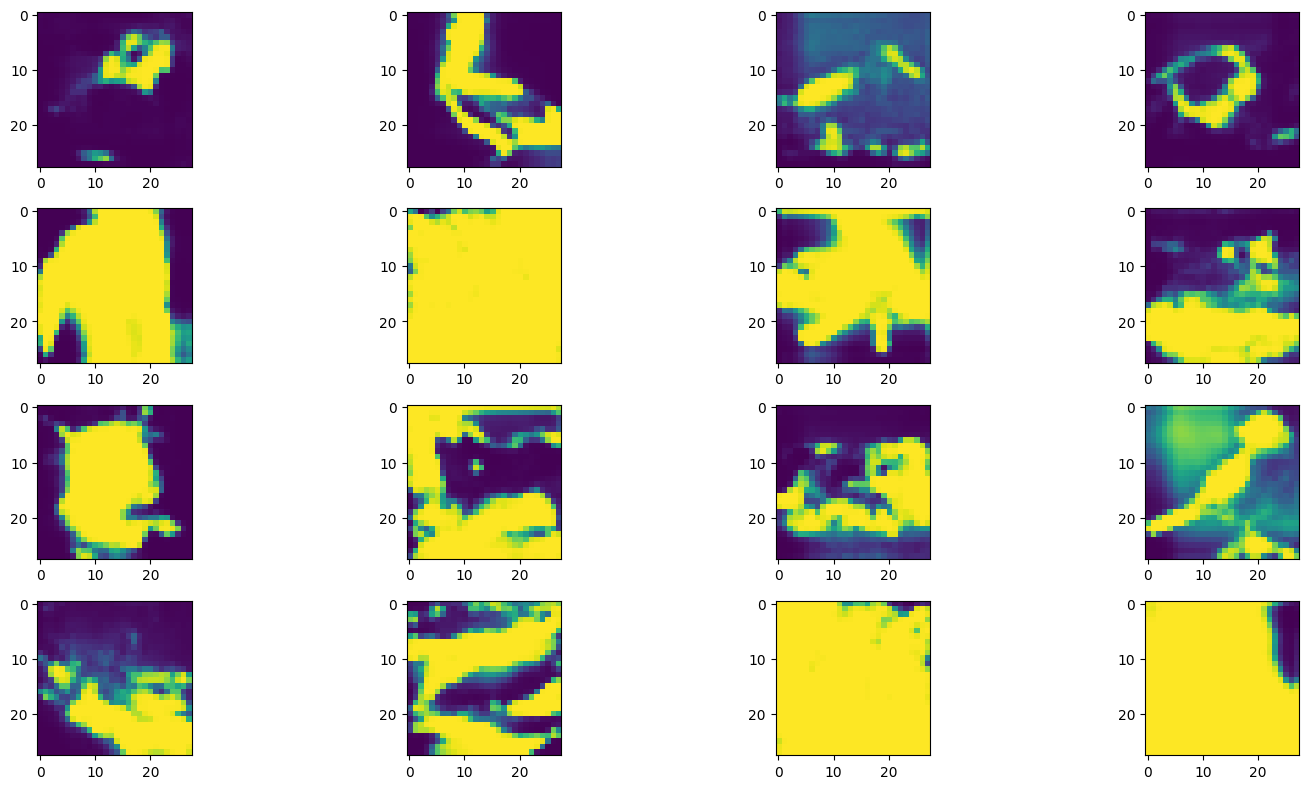

In [27]:
random_indices = np.random.randint(0, 90, size=16)

fig, axes = plt.subplots(4, 4, figsize=(16, 8))

# Plot each attention map
for i, ax in enumerate(axes.flatten()):
    with torch.no_grad():
        model.eval()
        img_tensor = temp_data[random_indices[i]][0].unsqueeze(0).to(device)
        attention_map = model(img_tensor).cpu().numpy()
    ax.imshow(attention_map[0][0])


plt.tight_layout()
plt.show()


## Visualing Convolution Output of Layers

In [28]:
def layer_viz(model, input_image_path):
    # Load the image and preprocess it
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = Image.open(input_image_path)
    input_tensor = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Forward pass to get the output of convolutional layers
    activations = []
    def hook(module, input, output):
        activations.append(output.cpu().numpy())
    hooks = []
    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook))

    # Pass input image through the model
    with torch.no_grad():
        model(input_tensor)
        
    activations = activations[::-1]


    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot the activations of each convolutional layer in subplots
    num_layers = len(activations)
    num_cols = min(num_layers, 4)  # Limit the number of columns in subplots
    num_rows = (num_layers - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i, activation in enumerate(activations):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(activation[0][0].squeeze(), cmap='viridis')
        axes[row_idx, col_idx].set_title(f'Layer {i+1}')
        axes[row_idx, col_idx].axis('off')
    plt.tight_layout()
    plt.show()

# Resnet

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


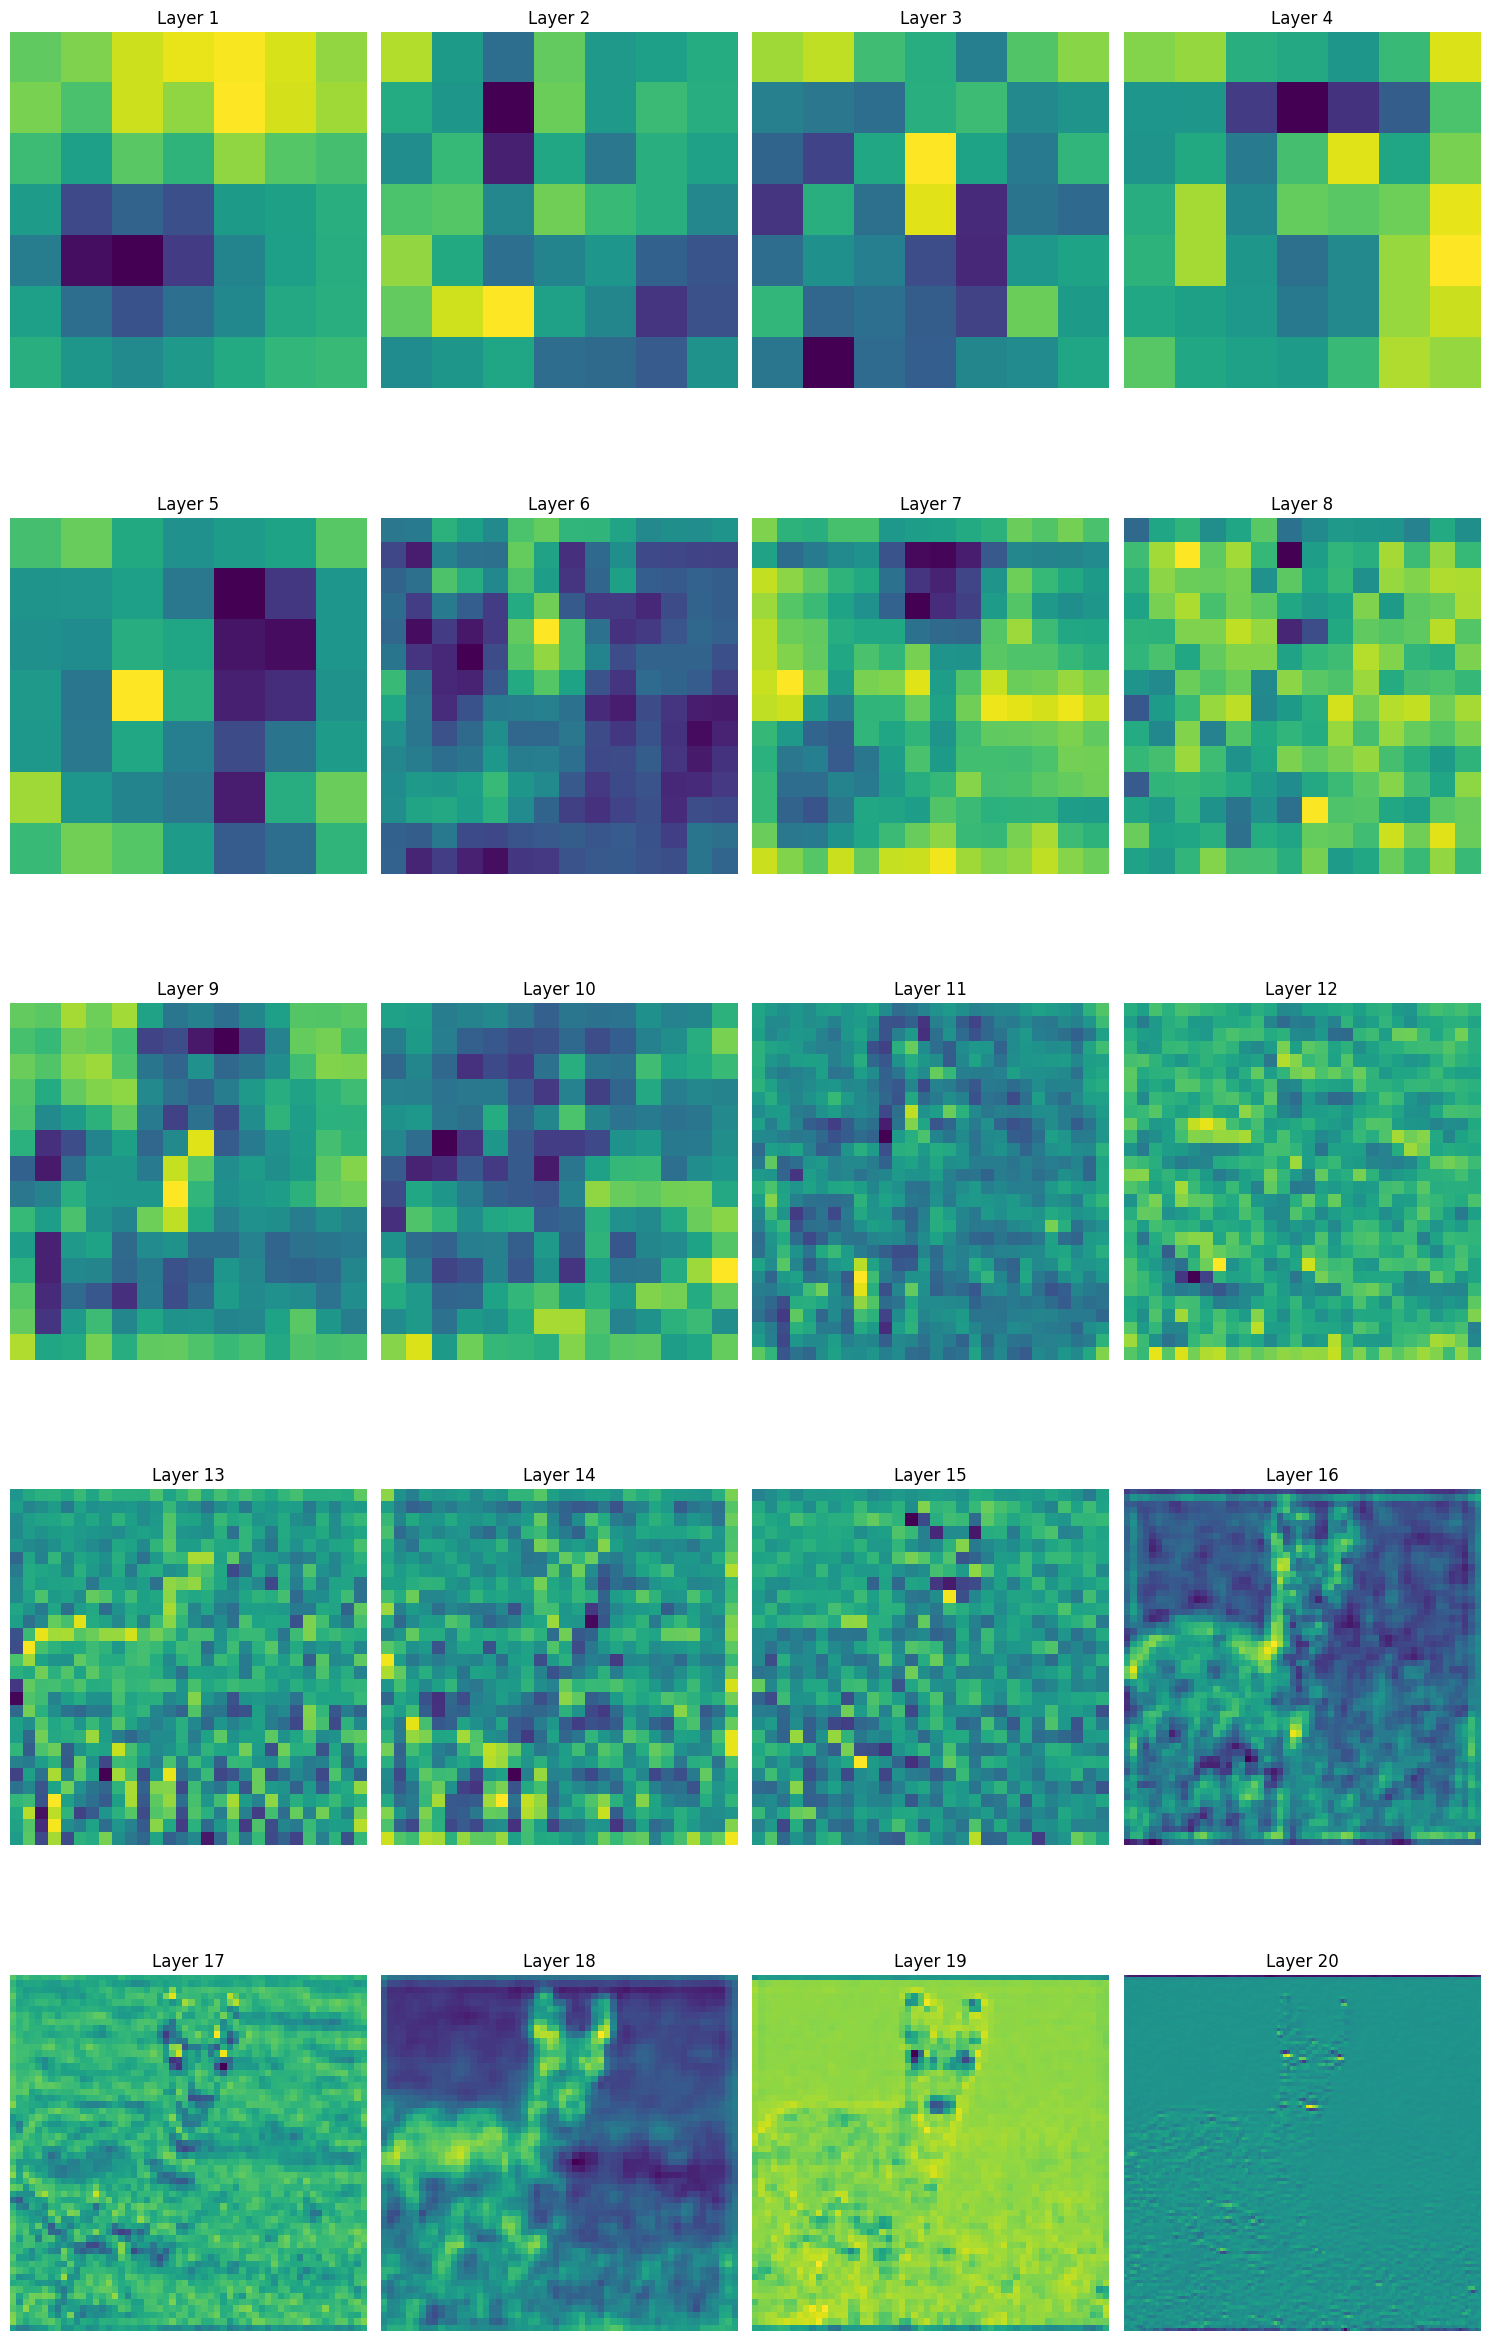

In [29]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512,5)
resnet.to(device)
resnet.load_state_dict(torch.load(f"Resnet_five_model.pth"))
# Usage example:
layer_viz(resnet, input_image_path="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/antelope/02f4b3be2d.jpg")


# EfficientNet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


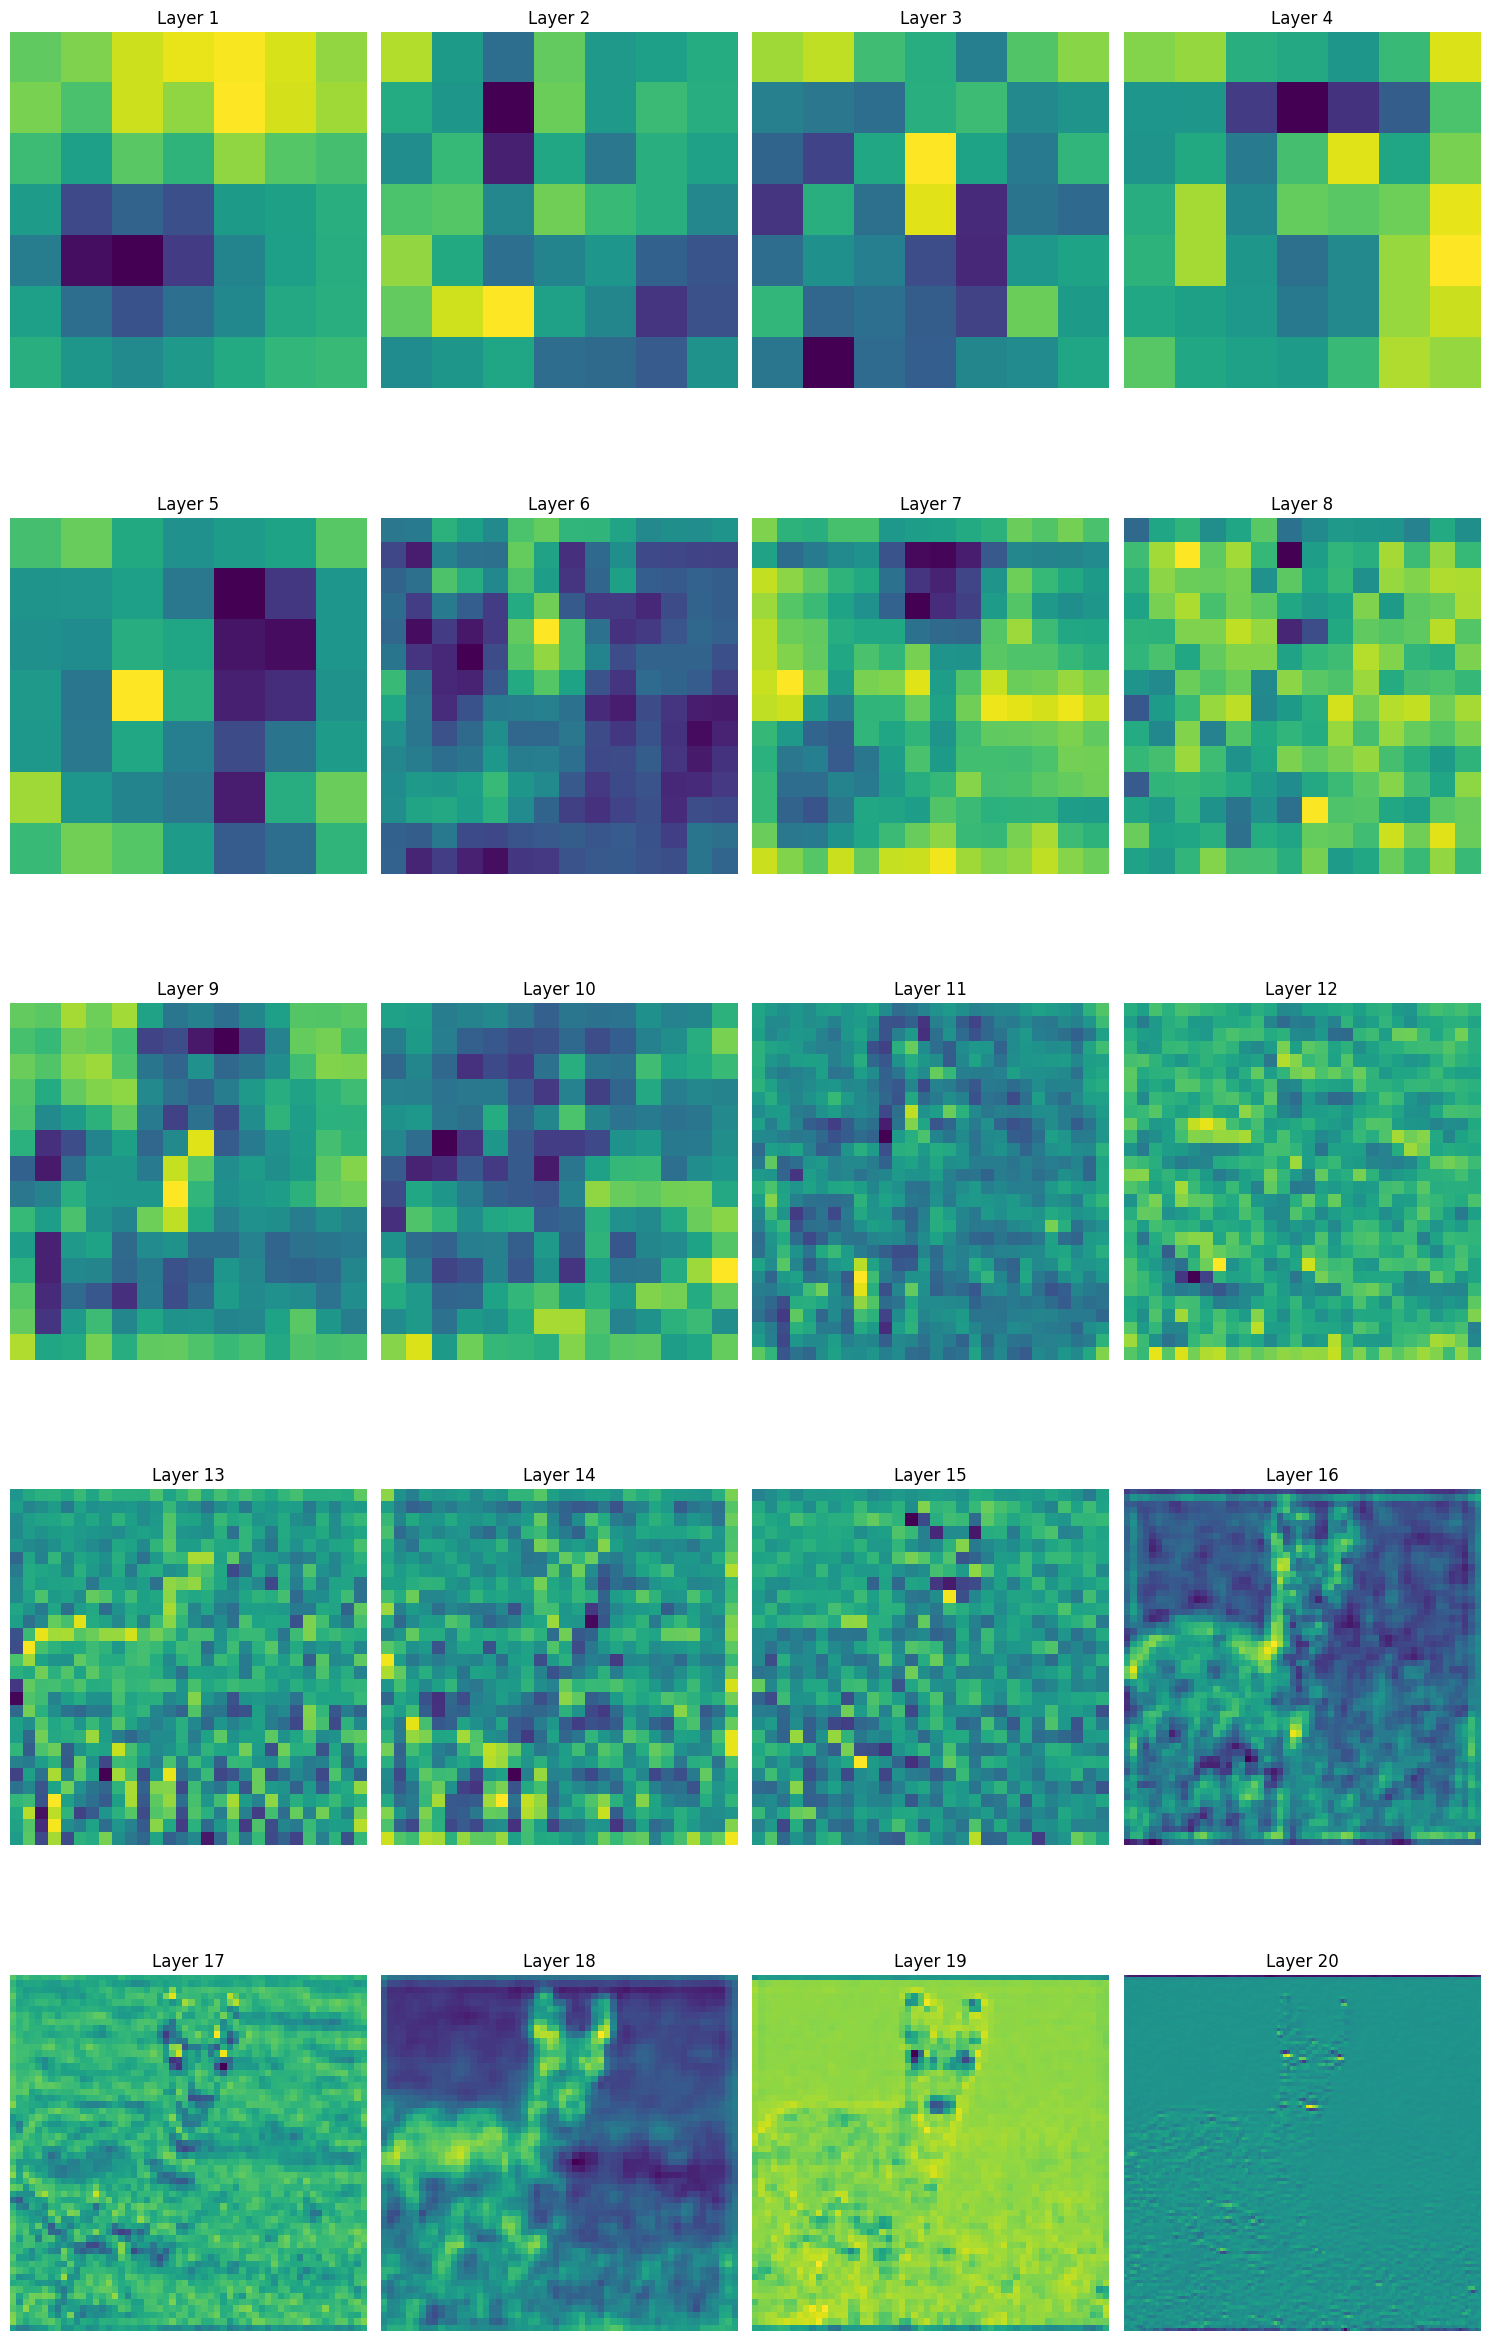

In [30]:
efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(1280,5)
efficientnet.to(device)
efficientnet.load_state_dict(torch.load("EfficientNet_five_model.pth"))
layer_viz(resnet, input_image_path="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/antelope/02f4b3be2d.jpg")


## CustomModel

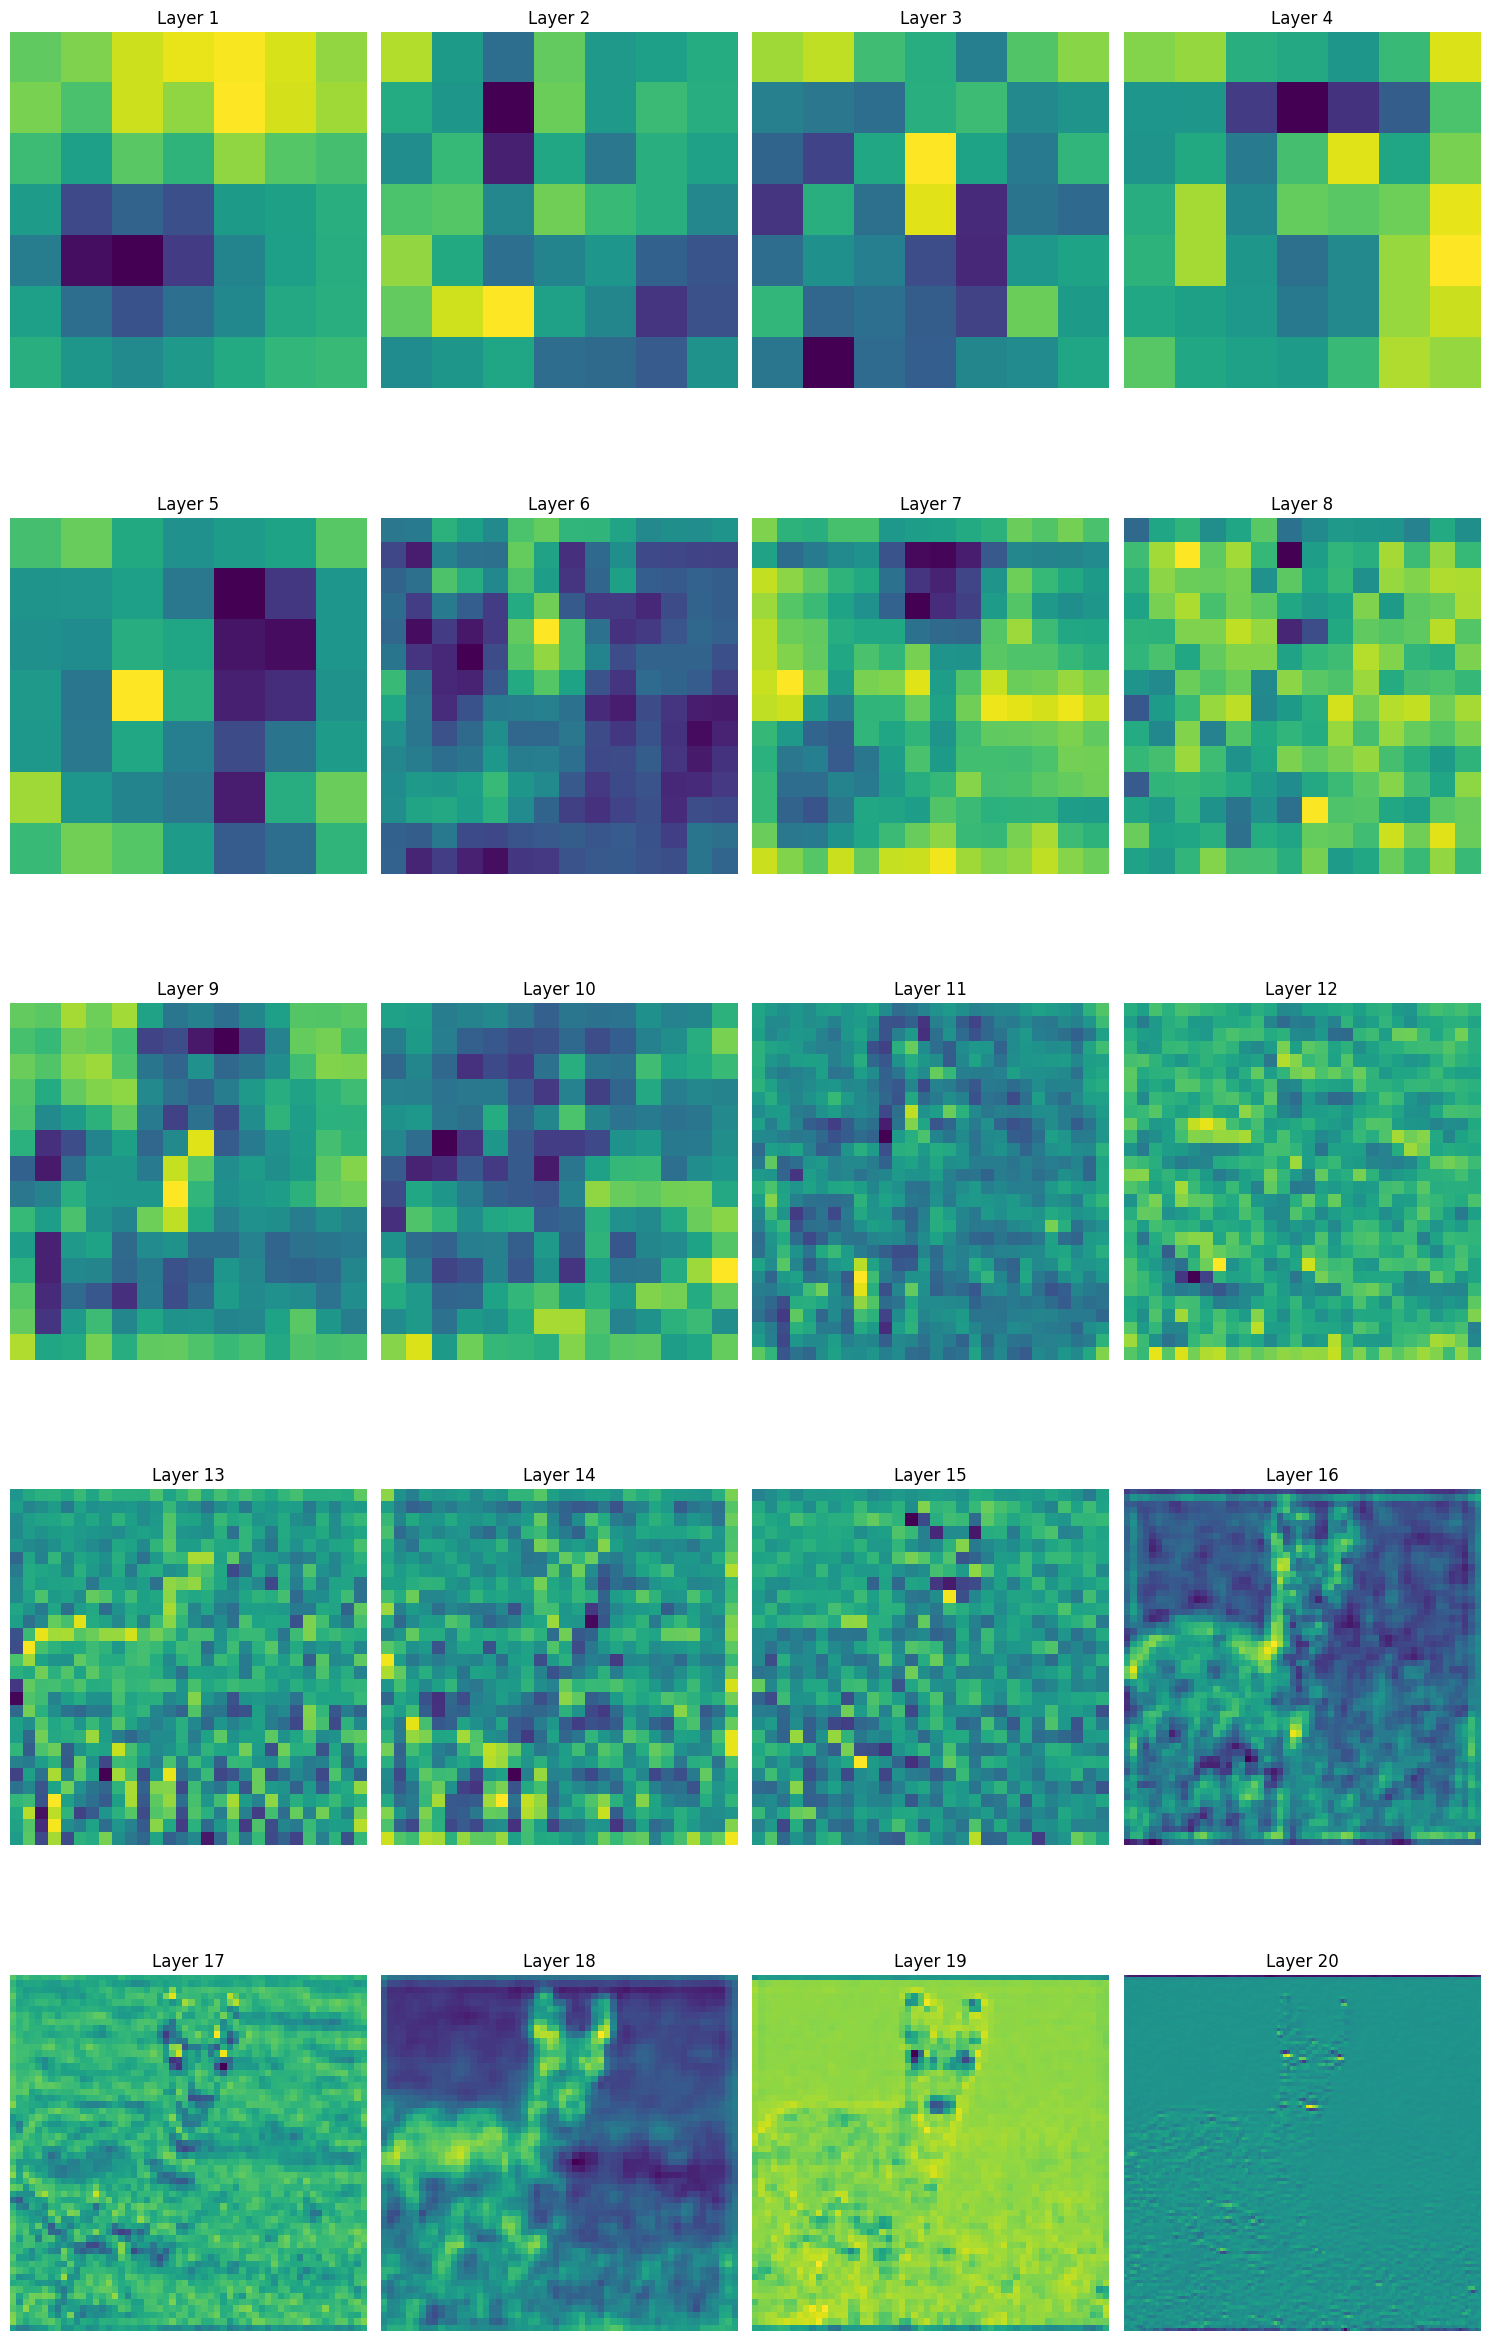

In [31]:
model = Model(2).to(device)
model.load_state_dict(torch.load(f"CustomAttModel_bi_model.pth"))
layer_viz(resnet, input_image_path="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/antelope/02f4b3be2d.jpg")


## Double Descent for custommodel performance

* in othermodels loss and accuracy is as expected.
* but in CustomAttentionModel accuracy is first increasing then decreasing due to generalisation error but if we see on fold 3 it is again increasing. it can be explained with **Double Descent** it is **counter intuitive** pattern observed, when in over parametrised models generalisation error increases after overfitting.

ref:[https://mlu-explain.github.io/double-descent/]

## layer outputs

* Convolution is our prior knowledge inserted into neural nets that pixels are dependent around its neighbours.but we dont define how it is related and it is learned. 
* each layer is like a building block of images of evolving hierachy, where first learn lines and edges then laters comple features like face and eye.

# Additional Refrences

# https://github.com/Autobot37/MachineLearningEngine for training code
# SPCOM2024 PaperID204 code [i am 2nd author] 